In [1]:
import os

def adjust_wkdir(cut_folder='notebook'):
    abspath = os.path.abspath('.')
    wk_dir = abspath.replace(cut_folder,'')
    os.chdir(wk_dir)
    return wk_dir


adjust_wkdir()

'/share/felix/pj/lung_classify/'

In [2]:


import logging
logging.basicConfig(level=logging.INFO)

import pandas as pd
import os
from task_distribute.locker import task_locker
from file_cache.cache import file_cache, logger, timed

#from tqdm._tqdm_notebook import tqdm_notebook as  tqdm

from tqdm import tqdm, tqdm_notebook
from glob import glob
import itertools
import numpy as np
from easydict import EasyDict as edict

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)



INFO:root:Start the program at:amax3, 10.10.20.103, with:Load module


yes


In [3]:
df = pd.read_csv('./input/train_bboxes.csv')
gp = df.groupby('filename').x.count().sort_index()

count_img = len(glob('./input/train/*.jpg'))
print(df.shape, gp.shape, count_img)
df.head(3)

(7167, 5) (4509,) 20013


,filename,x,y,width,height
0,6,287.0,673.0,188.0,220.0
1,8,651.0,476.0,250.0,344.0
2,18,220.0,414.0,142.0,120.0


In [4]:
df = pd.read_csv('./input/train_bboxes.csv')
df = df.drop_duplicates('filename')
df['fold'] = df.filename%5
df.fold.value_counts()

INFO:numexpr.utils:Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


1    935
2    925
4    884
0    884
3    881
Name: fold, dtype: int64

In [5]:
df = pd.read_csv('./input/train.csv', names=['filename', 'label'])
#df.head()

df.label.value_counts()

0    15504
2     2450
1     1960
3       89
4       10
Name: label, dtype: int64

In [6]:
import matplotlib.pyplot as plt
from glob import glob

file_list = list(glob('./input/train/*.jpg'))[:8]
print(file_list)
img_list = [plt.imread (file) for file in file_list]


from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

fig = plt.figure(figsize=(20., 50.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2,4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 share_all=True,
                 )

for ax, im in zip(grid, img_list):
    # Iterating over the grid returns the Axes.
    ax.imshow(im,cmap='gray')
plt.show()

['./input/train/8755.jpg', './input/train/158.jpg', './input/train/1570.jpg', './input/train/4223.jpg', './input/train/312.jpg', './input/train/9240.jpg', './input/train/9708.jpg', './input/train/19325.jpg']


<Figure size 2000x5000 with 16 Axes>

In [7]:
fold=(3,)
box_cnt=2
cls = pd.read_csv('./input/train.csv', names=['filename', 'label'])#.sample(100)
cls['fold'] = cls.filename%5
if fold:
    cls = cls.loc[cls.fold.isin(fold)]
if box_cnt is not None:
    df = pd.read_csv('./input/train_bboxes.csv')
    tmp = df.groupby('filename').filename.count().sort_values()
    tmp = tmp.loc[tmp==box_cnt]
    if box_cnt > 0:
        cls = cls.loc[cls.filename.isin(tmp.index)]
    else:
        cls = cls.loc[~cls.filename.isin(tmp.index)]

len(cls)


486

In [8]:
import os
import numpy as np
import json
import cv2
import random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode
from functools import lru_cache

@lru_cache()
def get_anotation_dicts(fold_name=None, box_cnt=None):
    
    fold_map = {
        'train':(0,1,2,3),
        'val_0':(0,),
        'val_1':(1,),
        'val_2':(2,),
        'val_3':(3,),
        'val_4':(4,),
    }
    fold = fold_map.get(fold_name)
    cls = pd.read_csv('./input/train.csv', names=['filename', 'label'])#.sample(100)
    cls['fold'] = cls.filename%5
    if fold:
        cls = cls.loc[cls.fold.isin(fold)]
    if box_cnt is not None:
        df = pd.read_csv('./input/train_bboxes.csv')
        tmp = df.groupby('filename').filename.count().sort_values()
        if box_cnt == 0:
            cls = cls.loc[~cls.filename.isin(tmp.index)]
        else:
            tmp = tmp.loc[tmp==box_cnt]
            cls = cls.loc[cls.filename.isin(tmp.index)]
            
    
    bbox= pd.read_csv('./input/train_bboxes.csv')

    dataset_dicts = []
    for idx, v in tqdm(cls.iterrows(),  desc=f'gen_annotaion_{str(fold_name)}', total=len(cls)):
        record = {}
        filename = v["filename"]
        #filename = os.path.join(img_dir, v["filename"])
        height, width = 1024, 1024 #cv2.imread(f'input/train/{filename}.jpg').shape[:2]
        #print(height, width)
        
        record["file_name"] = f'input/train/{filename}.jpg'
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      

        objs = []
        for _, anno in bbox.loc[bbox.filename==v["filename"]].iterrows():
#             assert not anno["region_attributes"]
#             anno = anno["shape_attributes"]
#             px = anno["all_points_x"]
#             py = anno["all_points_y"]
#             poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
#             poly = [p for x in poly for p in x]
           
            if len(anno)>0 :
                #print(anno)
                obj = {
                    "bbox": [anno.x, anno.y, anno.width, anno.height],
                    "bbox_mode": BoxMode.XYWH_ABS,
                    "category_id": 0,
                    "thing_classes": 'bz',
                    "iscrowd": 0
                }
                objs.append(obj)
        if objs:
            record["annotations"] = objs
            
        if objs or box_cnt == 0:
            dataset_dicts.append(record)
    print(f'dataset_dicts={len(dataset_dicts)} with fold:{fold}, box_cnt:{box_cnt}')
    return dataset_dicts



In [9]:
# for i in range(5):
#     i = get_anotation_dicts((i,))
#     print(len(i))
#get_anotation_dicts((4,))

In [10]:


from detectron2.data import DatasetCatalog, MetadataCatalog
DatasetCatalog.clear()
for d in ["train", "val_0", "val_1", "val_2", "val_3", "val_4"]:
    name = "lung_" + d  
    if name not in DatasetCatalog.list():
        print(d)
        DatasetCatalog.register(name, lambda d=d: get_anotation_dicts(d))
        MetadataCatalog.get(name).set(thing_classes=["bz"])
metadata = MetadataCatalog.get("lung_train")



train
val_0
val_1
val_2
val_3
val_4


In [11]:
DatasetCatalog.get('lung_val_1')

gen_annotaion_val_1: 100%|██████████| 4003/4003 [00:03<00:00, 1007.17it/s]


dataset_dicts=935 with fold:(1,), box_cnt:None


[{'file_name': 'input/train/6.jpg',
  'image_id': 6,
  'height': 1024,
  'width': 1024,
  'annotations': [{'bbox': [287.0, 673.0, 188.0, 220.0],
    'bbox_mode': <BoxMode.XYWH_ABS: 1>,
    'category_id': 0,
    'thing_classes': 'bz',
    'iscrowd': 0}]},
 {'file_name': 'input/train/36.jpg',
  'image_id': 36,
  'height': 1024,
  'width': 1024,
  'annotations': [{'bbox': [267.0, 328.0, 310.0, 309.0],
    'bbox_mode': <BoxMode.XYWH_ABS: 1>,
    'category_id': 0,
    'thing_classes': 'bz',
    'iscrowd': 0}]},
 {'file_name': 'input/train/51.jpg',
  'image_id': 51,
  'height': 1024,
  'width': 1024,
  'annotations': [{'bbox': [199.0, 460.0, 187.0, 176.0],
    'bbox_mode': <BoxMode.XYWH_ABS: 1>,
    'category_id': 0,
    'thing_classes': 'bz',
    'iscrowd': 0},
   {'bbox': [685.0, 590.0, 142.0, 160.0],
    'bbox_mode': <BoxMode.XYWH_ABS: 1>,
    'category_id': 0,
    'thing_classes': 'bz',
    'iscrowd': 0}]},
 {'file_name': 'input/train/101.jpg',
  'image_id': 101,
  'height': 1024,
  'wid

In [12]:
dataset_dicts = get_anotation_dicts(fold_name='train')

gen_annotaion_train: 100%|██████████| 16011/16011 [00:15<00:00, 1008.54it/s]

dataset_dicts=3625 with fold:(0, 1, 2, 3), box_cnt:None


input/train/6.jpg
input/train/8.jpg
input/train/18.jpg
input/train/27.jpg
input/train/28.jpg
input/train/30.jpg
input/train/36.jpg
input/train/50.jpg


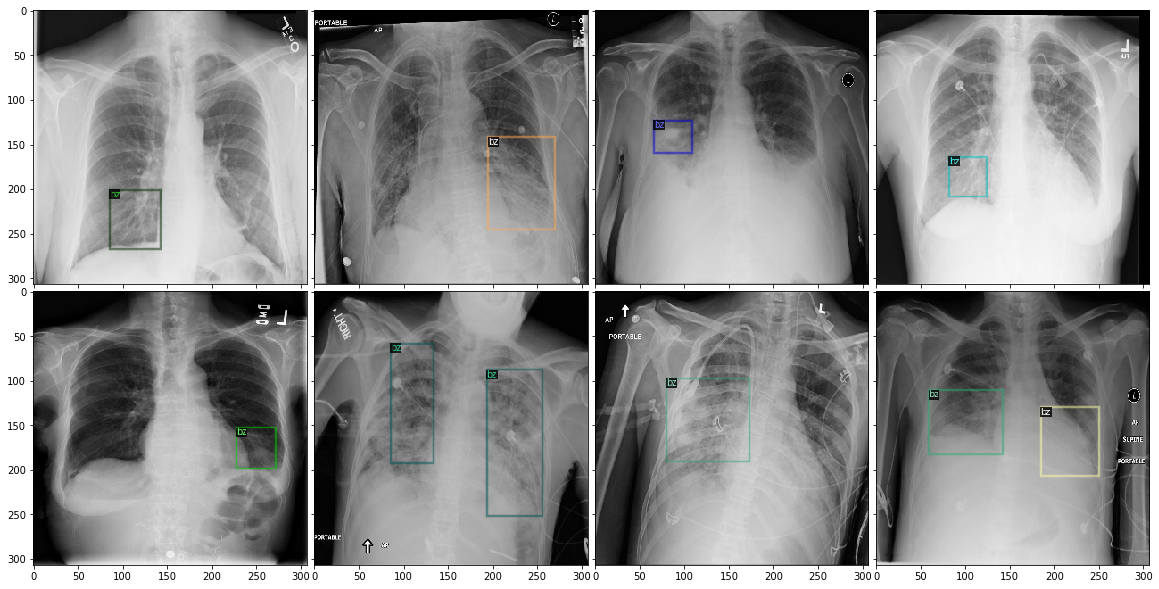

In [13]:
# Sample image, and show it

img_list =[]
for d in dataset_dicts[:8]:
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.3)
    vis = visualizer.draw_dataset_dict(d)
    #
    img_list.append(vis.get_image()[:, :, ::-1])

fig = plt.figure(figsize=(20., 50.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2,4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 share_all=True,
                 )

for ax, im in zip(grid, img_list):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()

In [14]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("lung_train",)
cfg.DATASETS.TEST = ()

cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.TEST.EVAL_PERIOD = 1000
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


In [19]:
from detectron2.evaluation.coco_evaluation import COCOEvaluator
cfg.DATASETS.TEST = ("lung_val_4","lung_val_2", )
BATCH_SIZE=128  
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = BATCH_SIZE   # faster, and good enough for this toy dataset (default: 512)
cfg.SOLVER.MAX_ITER = 50000
print(f'BATCH_SIZE={BATCH_SIZE}, MAX_ITER={cfg.SOLVER.MAX_ITER}')

class _Trainer(DefaultTrainer):
    def __init__(self, cfg):
        super().__init__(cfg)
        
    def build_evaluator(cfg, dataset_name):   
        output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
    
    def build_hooks(self):
        ret = super().build_hooks()
        return ret
    
    
trainer = _Trainer(cfg) 

    
trainer.resume_or_load(resume=True)

trainer.train()

BATCH_SIZE=128, MAX_ITER=50000


INFO:detectron2.engine.defaults:Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Seq

INFO:detectron2.data.build:Removed 0 images with no usable annotations. 3625 images left.
INFO:detectron2.data.detection_utils:TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
INFO:detectron2.data.build:Using training sampler TrainingSampler
INFO:fvcore.common.checkpoint:Loading checkpoint from ./output/model_0029999.pth
INFO:fvcore.common.checkpoint:Loading optimizer from ./output/model_0029999.pth
INFO:fvcore.common.checkpoint:Loading scheduler from ./output/model_0029999.pth
INFO:detectron2.engine.train_loop:Starting training from iteration 30000
INFO:detectron2.utils.events:eta: 1:09:57  iter: 30019  total_loss: 0.297  loss_cls: 0.159  loss_box_reg: 0.151  time: 0.2076  data_time: 0.0183  lr: 0.000250  max_mem: 4289M
INFO:detectron2.utils.events:eta: 1:05:56  iter: 30039  total_loss: 0.309  loss_cls: 0.166  loss_box_reg: 0.140  time: 0.2024  data_time: 0.0046  lr: 0.000250  max

INFO:detectron2.utils.events:eta: 1:03:13  iter: 30899  total_loss: 0.340  loss_cls: 0.179  loss_box_reg: 0.153  time: 0.2025  data_time: 0.0047  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 1:03:05  iter: 30919  total_loss: 0.243  loss_cls: 0.123  loss_box_reg: 0.113  time: 0.2024  data_time: 0.0049  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 1:03:03  iter: 30939  total_loss: 0.252  loss_cls: 0.125  loss_box_reg: 0.130  time: 0.2025  data_time: 0.0048  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 1:03:02  iter: 30959  total_loss: 0.282  loss_cls: 0.146  loss_box_reg: 0.144  time: 0.2026  data_time: 0.0046  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 1:02:52  iter: 30979  total_loss: 0.282  loss_cls: 0.152  loss_box_reg: 0.130  time: 0.2024  data_time: 0.0047  lr: 0.000250  max_mem: 4290M
INFO:detectron2.evaluation.evaluator:Start inference on 884 images
INFO:detectron2.evaluation.evaluator:Inference done 11/884

INFO:detectron2.utils.events:eta: 1:00:35  iter: 31839  total_loss: 0.305  loss_cls: 0.153  loss_box_reg: 0.143  time: 0.2040  data_time: 0.0047  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 1:00:31  iter: 31859  total_loss: 0.212  loss_cls: 0.117  loss_box_reg: 0.104  time: 0.2040  data_time: 0.0052  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 1:00:29  iter: 31879  total_loss: 0.273  loss_cls: 0.123  loss_box_reg: 0.143  time: 0.2041  data_time: 0.0051  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 1:00:24  iter: 31899  total_loss: 0.283  loss_cls: 0.129  loss_box_reg: 0.157  time: 0.2040  data_time: 0.0047  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 1:00:26  iter: 31919  total_loss: 0.307  loss_cls: 0.149  loss_box_reg: 0.146  time: 0.2040  data_time: 0.0049  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 1:00:18  iter: 31939  total_loss: 0.227  loss_cls: 0.114  loss_box_reg: 0.108  time: 0.2041

Loading and preparing results...
DONE (t=0.23s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.54s).
Accumulating evaluation results...
DONE (t=0.20s).


INFO:detectron2.evaluation.coco_evaluation:Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |   APs    |  APm  |  APl   |
|:------:|:------:|:------:|:--------:|:-----:|:------:|
| 14.920 | 48.124 | 4.898  | -100.000 | 5.955 | 15.020 |
INFO:detectron2.engine.defaults:Evaluation results for lung_val_4 in csv format:
INFO:detectron2.evaluation.testing:copypaste: Task: bbox
INFO:detectron2.evaluation.testing:copypaste: AP,AP50,AP75,APs,APm,APl
INFO:detectron2.evaluation.testing:copypaste: 14.9204,48.1243,4.8976,-100.0000,5.9548,15.0204
INFO:detectron2.evaluation.evaluator:Start inference on 925 images


 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.149
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.481
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.049
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.060
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.150
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.151
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.383
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.419
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.073
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.421


INFO:detectron2.evaluation.evaluator:Inference done 11/925. 0.0700 s / img. ETA=0:01:05
INFO:detectron2.evaluation.evaluator:Inference done 81/925. 0.0699 s / img. ETA=0:01:00
INFO:detectron2.evaluation.evaluator:Inference done 150/925. 0.0702 s / img. ETA=0:00:55
INFO:detectron2.evaluation.evaluator:Inference done 219/925. 0.0703 s / img. ETA=0:00:51
INFO:detectron2.evaluation.evaluator:Inference done 289/925. 0.0703 s / img. ETA=0:00:46
INFO:detectron2.evaluation.evaluator:Inference done 359/925. 0.0703 s / img. ETA=0:00:40
INFO:detectron2.evaluation.evaluator:Inference done 429/925. 0.0703 s / img. ETA=0:00:35
INFO:detectron2.evaluation.evaluator:Inference done 498/925. 0.0704 s / img. ETA=0:00:30
INFO:detectron2.evaluation.evaluator:Inference done 566/925. 0.0705 s / img. ETA=0:00:26
INFO:detectron2.evaluation.evaluator:Inference done 636/925. 0.0705 s / img. ETA=0:00:20
INFO:detectron2.evaluation.evaluator:Inference done 705/925. 0.0705 s / img. ETA=0:00:15
INFO:detectron2.evaluat

Loading and preparing results...
DONE (t=0.23s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.54s).
Accumulating evaluation results...


INFO:detectron2.evaluation.coco_evaluation:Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |   APs    |  APm   |  APl   |
|:------:|:------:|:------:|:--------:|:------:|:------:|
| 49.155 | 93.625 | 45.001 | -100.000 | 64.186 | 48.997 |
INFO:detectron2.engine.defaults:Evaluation results for lung_val_2 in csv format:
INFO:detectron2.evaluation.testing:copypaste: Task: bbox
INFO:detectron2.evaluation.testing:copypaste: AP,AP50,AP75,APs,APm,APl
INFO:detectron2.evaluation.testing:copypaste: 49.1551,93.6247,45.0010,-100.0000,64.1862,48.9967
INFO:detectron2.utils.events:eta: 1:00:07  iter: 31999  total_loss: 0.293  loss_cls: 0.158  loss_box_reg: 0.138  time: 0.2040  data_time: 0.0047  lr: 0.000250  max_mem: 4290M


DONE (t=0.22s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.492
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.936
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.450
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.642
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.490
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.368
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.597
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.606
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.707
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.605


INFO:detectron2.utils.events:eta: 1:00:07  iter: 32019  total_loss: 0.301  loss_cls: 0.169  loss_box_reg: 0.134  time: 0.2041  data_time: 0.0050  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 1:00:08  iter: 32039  total_loss: 0.251  loss_cls: 0.130  loss_box_reg: 0.114  time: 0.2042  data_time: 0.0050  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 1:00:05  iter: 32059  total_loss: 0.232  loss_cls: 0.119  loss_box_reg: 0.107  time: 0.2042  data_time: 0.0049  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 1:00:00  iter: 32079  total_loss: 0.291  loss_cls: 0.153  loss_box_reg: 0.138  time: 0.2042  data_time: 0.0046  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:59:57  iter: 32099  total_loss: 0.255  loss_cls: 0.117  loss_box_reg: 0.120  time: 0.2043  data_time: 0.0045  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:59:50  iter: 32119  total_loss: 0.274  loss_cls: 0.151  loss_box_reg: 0.129  time: 0.2043

INFO:detectron2.utils.events:eta: 0:57:40  iter: 32959  total_loss: 0.254  loss_cls: 0.127  loss_box_reg: 0.149  time: 0.2053  data_time: 0.0057  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:57:36  iter: 32979  total_loss: 0.263  loss_cls: 0.121  loss_box_reg: 0.145  time: 0.2053  data_time: 0.0048  lr: 0.000250  max_mem: 4290M
INFO:detectron2.evaluation.evaluator:Start inference on 884 images
INFO:detectron2.evaluation.evaluator:Inference done 11/884. 0.0705 s / img. ETA=0:01:02
INFO:detectron2.evaluation.evaluator:Inference done 80/884. 0.0707 s / img. ETA=0:00:58
INFO:detectron2.evaluation.evaluator:Inference done 149/884. 0.0706 s / img. ETA=0:00:53
INFO:detectron2.evaluation.evaluator:Inference done 218/884. 0.0706 s / img. ETA=0:00:48
INFO:detectron2.evaluation.evaluator:Inference done 287/884. 0.0706 s / img. ETA=0:00:43
INFO:detectron2.evaluation.evaluator:Inference done 356/884. 0.0707 s / img. ETA=0:00:38
INFO:detectron2.evaluation.evaluator:Inference done

Loading and preparing results...
DONE (t=0.21s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.51s).
Accumulating evaluation results...


INFO:detectron2.evaluation.coco_evaluation:Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |   APs    |  APm  |  APl   |
|:------:|:------:|:------:|:--------:|:-----:|:------:|
| 16.548 | 51.773 | 4.696  | -100.000 | 1.576 | 16.776 |
INFO:detectron2.engine.defaults:Evaluation results for lung_val_4 in csv format:
INFO:detectron2.evaluation.testing:copypaste: Task: bbox
INFO:detectron2.evaluation.testing:copypaste: AP,AP50,AP75,APs,APm,APl
INFO:detectron2.evaluation.testing:copypaste: 16.5481,51.7728,4.6960,-100.0000,1.5756,16.7760
INFO:detectron2.evaluation.evaluator:Start inference on 925 images


DONE (t=0.21s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.165
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.518
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.047
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.168
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.159
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.381
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.420
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.200
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.422


INFO:detectron2.evaluation.evaluator:Inference done 11/925. 0.0704 s / img. ETA=0:01:05
INFO:detectron2.evaluation.evaluator:Inference done 81/925. 0.0702 s / img. ETA=0:01:00
INFO:detectron2.evaluation.evaluator:Inference done 151/925. 0.0702 s / img. ETA=0:00:55
INFO:detectron2.evaluation.evaluator:Inference done 221/925. 0.0702 s / img. ETA=0:00:50
INFO:detectron2.evaluation.evaluator:Inference done 291/925. 0.0702 s / img. ETA=0:00:45
INFO:detectron2.evaluation.evaluator:Inference done 361/925. 0.0702 s / img. ETA=0:00:40
INFO:detectron2.evaluation.evaluator:Inference done 430/925. 0.0702 s / img. ETA=0:00:35
INFO:detectron2.evaluation.evaluator:Inference done 500/925. 0.0702 s / img. ETA=0:00:30
INFO:detectron2.evaluation.evaluator:Inference done 570/925. 0.0702 s / img. ETA=0:00:25
INFO:detectron2.evaluation.evaluator:Inference done 640/925. 0.0702 s / img. ETA=0:00:20
INFO:detectron2.evaluation.evaluator:Inference done 710/925. 0.0702 s / img. ETA=0:00:15
INFO:detectron2.evaluat

Loading and preparing results...
DONE (t=0.21s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.54s).
Accumulating evaluation results...


INFO:detectron2.evaluation.coco_evaluation:Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |   APs    |  APm   |  APl   |
|:------:|:------:|:------:|:--------:|:------:|:------:|
| 47.412 | 92.933 | 41.797 | -100.000 | 58.533 | 47.394 |
INFO:detectron2.engine.defaults:Evaluation results for lung_val_2 in csv format:
INFO:detectron2.evaluation.testing:copypaste: Task: bbox
INFO:detectron2.evaluation.testing:copypaste: AP,AP50,AP75,APs,APm,APl
INFO:detectron2.evaluation.testing:copypaste: 47.4123,92.9330,41.7967,-100.0000,58.5325,47.3941
INFO:detectron2.utils.events:eta: 0:57:31  iter: 32999  total_loss: 0.285  loss_cls: 0.151  loss_box_reg: 0.144  time: 0.2053  data_time: 0.0047  lr: 0.000250  max_mem: 4290M


DONE (t=0.21s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.474
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.929
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.418
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.585
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.474
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.351
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.587
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.592
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.591


INFO:detectron2.utils.events:eta: 0:57:25  iter: 33019  total_loss: 0.289  loss_cls: 0.164  loss_box_reg: 0.127  time: 0.2053  data_time: 0.0049  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:57:18  iter: 33039  total_loss: 0.310  loss_cls: 0.165  loss_box_reg: 0.149  time: 0.2053  data_time: 0.0052  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:57:13  iter: 33059  total_loss: 0.312  loss_cls: 0.144  loss_box_reg: 0.149  time: 0.2053  data_time: 0.0048  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:57:08  iter: 33079  total_loss: 0.274  loss_cls: 0.131  loss_box_reg: 0.144  time: 0.2053  data_time: 0.0047  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:57:02  iter: 33099  total_loss: 0.258  loss_cls: 0.109  loss_box_reg: 0.130  time: 0.2053  data_time: 0.0046  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:56:55  iter: 33119  total_loss: 0.273  loss_cls: 0.130  loss_box_reg: 0.138  time: 0.2053

INFO:detectron2.utils.events:eta: 0:54:17  iter: 33959  total_loss: 0.263  loss_cls: 0.132  loss_box_reg: 0.118  time: 0.2060  data_time: 0.0047  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:54:15  iter: 33979  total_loss: 0.221  loss_cls: 0.108  loss_box_reg: 0.097  time: 0.2060  data_time: 0.0048  lr: 0.000250  max_mem: 4290M
INFO:detectron2.evaluation.evaluator:Start inference on 884 images
INFO:detectron2.evaluation.evaluator:Inference done 11/884. 0.0722 s / img. ETA=0:01:04
INFO:detectron2.evaluation.evaluator:Inference done 79/884. 0.0715 s / img. ETA=0:00:59
INFO:detectron2.evaluation.evaluator:Inference done 148/884. 0.0710 s / img. ETA=0:00:53
INFO:detectron2.evaluation.evaluator:Inference done 217/884. 0.0708 s / img. ETA=0:00:48
INFO:detectron2.evaluation.evaluator:Inference done 286/884. 0.0707 s / img. ETA=0:00:43
INFO:detectron2.evaluation.evaluator:Inference done 355/884. 0.0707 s / img. ETA=0:00:38
INFO:detectron2.evaluation.evaluator:Inference done

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


INFO:detectron2.evaluation.coco_evaluation:Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |   APs    |  APm  |  APl   |
|:------:|:------:|:------:|:--------:|:-----:|:------:|
| 15.442 | 49.757 | 4.208  | -100.000 | 0.971 | 15.555 |
INFO:detectron2.engine.defaults:Evaluation results for lung_val_4 in csv format:
INFO:detectron2.evaluation.testing:copypaste: Task: bbox
INFO:detectron2.evaluation.testing:copypaste: AP,AP50,AP75,APs,APm,APl
INFO:detectron2.evaluation.testing:copypaste: 15.4420,49.7573,4.2075,-100.0000,0.9705,15.5548


DONE (t=1.16s).
Accumulating evaluation results...
DONE (t=0.17s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.154
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.498
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.042
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.151
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.380
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.405
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.091
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

INFO:detectron2.evaluation.evaluator:Start inference on 925 images
INFO:detectron2.evaluation.evaluator:Inference done 11/925. 0.0700 s / img. ETA=0:01:05
INFO:detectron2.evaluation.evaluator:Inference done 81/925. 0.0699 s / img. ETA=0:01:00
INFO:detectron2.evaluation.evaluator:Inference done 151/925. 0.0701 s / img. ETA=0:00:55
INFO:detectron2.evaluation.evaluator:Inference done 221/925. 0.0700 s / img. ETA=0:00:50
INFO:detectron2.evaluation.evaluator:Inference done 291/925. 0.0700 s / img. ETA=0:00:45
INFO:detectron2.evaluation.evaluator:Inference done 361/925. 0.0699 s / img. ETA=0:00:40
INFO:detectron2.evaluation.evaluator:Inference done 431/925. 0.0699 s / img. ETA=0:00:35
INFO:detectron2.evaluation.evaluator:Inference done 501/925. 0.0699 s / img. ETA=0:00:30
INFO:detectron2.evaluation.evaluator:Inference done 571/925. 0.0699 s / img. ETA=0:00:25
INFO:detectron2.evaluation.evaluator:Inference done 641/925. 0.0700 s / img. ETA=0:00:20
INFO:detectron2.evaluation.evaluator:Inferenc

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


INFO:detectron2.evaluation.coco_evaluation:Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |   APs    |  APm   |  APl   |
|:------:|:------:|:------:|:--------:|:------:|:------:|
| 51.271 | 94.908 | 48.897 | -100.000 | 61.509 | 51.216 |
INFO:detectron2.engine.defaults:Evaluation results for lung_val_2 in csv format:
INFO:detectron2.evaluation.testing:copypaste: Task: bbox
INFO:detectron2.evaluation.testing:copypaste: AP,AP50,AP75,APs,APm,APl
INFO:detectron2.evaluation.testing:copypaste: 51.2712,94.9077,48.8967,-100.0000,61.5093,51.2158
INFO:detectron2.utils.events:eta: 0:54:12  iter: 33999  total_loss: 0.225  loss_cls: 0.117  loss_box_reg: 0.117  time: 0.2060  data_time: 0.0049  lr: 0.000250  max_mem: 4290M


DONE (t=1.25s).
Accumulating evaluation results...
DONE (t=0.17s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.513
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.949
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.489
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.615
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.512
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.379
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.609
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.612
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.693
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

INFO:detectron2.utils.events:eta: 0:54:06  iter: 34019  total_loss: 0.230  loss_cls: 0.119  loss_box_reg: 0.116  time: 0.2060  data_time: 0.0051  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:54:03  iter: 34039  total_loss: 0.232  loss_cls: 0.122  loss_box_reg: 0.122  time: 0.2060  data_time: 0.0050  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:54:00  iter: 34059  total_loss: 0.274  loss_cls: 0.133  loss_box_reg: 0.129  time: 0.2060  data_time: 0.0048  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:53:57  iter: 34079  total_loss: 0.278  loss_cls: 0.151  loss_box_reg: 0.122  time: 0.2060  data_time: 0.0053  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:53:52  iter: 34099  total_loss: 0.268  loss_cls: 0.129  loss_box_reg: 0.146  time: 0.2059  data_time: 0.0050  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:53:48  iter: 34119  total_loss: 0.305  loss_cls: 0.128  loss_box_reg: 0.149  time: 0.2059

INFO:detectron2.utils.events:eta: 0:50:41  iter: 34959  total_loss: 0.251  loss_cls: 0.127  loss_box_reg: 0.121  time: 0.2062  data_time: 0.0049  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:50:33  iter: 34979  total_loss: 0.303  loss_cls: 0.157  loss_box_reg: 0.140  time: 0.2062  data_time: 0.0052  lr: 0.000250  max_mem: 4290M
INFO:fvcore.common.checkpoint:Saving checkpoint to ./output/model_0034999.pth
INFO:detectron2.evaluation.evaluator:Start inference on 884 images
INFO:detectron2.evaluation.evaluator:Inference done 11/884. 0.0705 s / img. ETA=0:01:03
INFO:detectron2.evaluation.evaluator:Inference done 80/884. 0.0704 s / img. ETA=0:00:58
INFO:detectron2.evaluation.evaluator:Inference done 147/884. 0.0717 s / img. ETA=0:00:54
INFO:detectron2.evaluation.evaluator:Inference done 216/884. 0.0714 s / img. ETA=0:00:49
INFO:detectron2.evaluation.evaluator:Inference done 284/884. 0.0714 s / img. ETA=0:00:44
INFO:detectron2.evaluation.evaluator:Inference done 353/884. 0

Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.61s).
Accumulating evaluation results...


INFO:detectron2.evaluation.coco_evaluation:Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |   APs    |  APm  |  APl   |
|:------:|:------:|:------:|:--------:|:-----:|:------:|
| 15.147 | 49.483 | 4.454  | -100.000 | 0.657 | 15.272 |
INFO:detectron2.engine.defaults:Evaluation results for lung_val_4 in csv format:
INFO:detectron2.evaluation.testing:copypaste: Task: bbox
INFO:detectron2.evaluation.testing:copypaste: AP,AP50,AP75,APs,APm,APl
INFO:detectron2.evaluation.testing:copypaste: 15.1469,49.4827,4.4543,-100.0000,0.6565,15.2719
INFO:detectron2.evaluation.evaluator:Start inference on 925 images


DONE (t=0.44s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.151
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.495
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.045
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.153
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.148
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.387
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.428
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.082
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.430


INFO:detectron2.evaluation.evaluator:Inference done 11/925. 0.0699 s / img. ETA=0:01:05
INFO:detectron2.evaluation.evaluator:Inference done 81/925. 0.0700 s / img. ETA=0:01:00
INFO:detectron2.evaluation.evaluator:Inference done 151/925. 0.0700 s / img. ETA=0:00:55
INFO:detectron2.evaluation.evaluator:Inference done 221/925. 0.0700 s / img. ETA=0:00:50
INFO:detectron2.evaluation.evaluator:Inference done 291/925. 0.0700 s / img. ETA=0:00:45
INFO:detectron2.evaluation.evaluator:Inference done 361/925. 0.0700 s / img. ETA=0:00:40
INFO:detectron2.evaluation.evaluator:Inference done 431/925. 0.0700 s / img. ETA=0:00:35
INFO:detectron2.evaluation.evaluator:Inference done 501/925. 0.0700 s / img. ETA=0:00:30
INFO:detectron2.evaluation.evaluator:Inference done 571/925. 0.0700 s / img. ETA=0:00:25
INFO:detectron2.evaluation.evaluator:Inference done 641/925. 0.0700 s / img. ETA=0:00:20
INFO:detectron2.evaluation.evaluator:Inference done 711/925. 0.0700 s / img. ETA=0:00:15
INFO:detectron2.evaluat

Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.61s).
Accumulating evaluation results...


INFO:detectron2.evaluation.coco_evaluation:Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |   APs    |  APm   |  APl   |
|:------:|:------:|:------:|:--------:|:------:|:------:|
| 50.298 | 94.071 | 47.240 | -100.000 | 66.558 | 50.088 |
INFO:detectron2.engine.defaults:Evaluation results for lung_val_2 in csv format:
INFO:detectron2.evaluation.testing:copypaste: Task: bbox
INFO:detectron2.evaluation.testing:copypaste: AP,AP50,AP75,APs,APm,APl
INFO:detectron2.evaluation.testing:copypaste: 50.2984,94.0710,47.2396,-100.0000,66.5578,50.0876
INFO:detectron2.utils.events:eta: 0:50:26  iter: 34999  total_loss: 0.270  loss_cls: 0.145  loss_box_reg: 0.133  time: 0.2062  data_time: 0.0048  lr: 0.000250  max_mem: 4290M


DONE (t=0.21s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.503
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.941
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.472
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.666
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.501
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.374
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.606
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.611
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.740
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.610


INFO:detectron2.utils.events:eta: 0:50:26  iter: 35019  total_loss: 0.302  loss_cls: 0.149  loss_box_reg: 0.141  time: 0.2062  data_time: 0.0047  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:50:20  iter: 35039  total_loss: 0.251  loss_cls: 0.140  loss_box_reg: 0.118  time: 0.2062  data_time: 0.0046  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:50:14  iter: 35059  total_loss: 0.264  loss_cls: 0.133  loss_box_reg: 0.162  time: 0.2062  data_time: 0.0053  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:50:12  iter: 35079  total_loss: 0.234  loss_cls: 0.102  loss_box_reg: 0.127  time: 0.2062  data_time: 0.0059  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:50:10  iter: 35099  total_loss: 0.263  loss_cls: 0.133  loss_box_reg: 0.138  time: 0.2063  data_time: 0.0050  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:50:06  iter: 35119  total_loss: 0.242  loss_cls: 0.118  loss_box_reg: 0.113  time: 0.2063

INFO:detectron2.utils.events:eta: 0:47:18  iter: 35959  total_loss: 0.255  loss_cls: 0.134  loss_box_reg: 0.117  time: 0.2064  data_time: 0.0048  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:47:15  iter: 35979  total_loss: 0.201  loss_cls: 0.105  loss_box_reg: 0.102  time: 0.2064  data_time: 0.0047  lr: 0.000250  max_mem: 4290M
INFO:detectron2.evaluation.evaluator:Start inference on 884 images
INFO:detectron2.evaluation.evaluator:Inference done 11/884. 0.0705 s / img. ETA=0:01:02
INFO:detectron2.evaluation.evaluator:Inference done 80/884. 0.0709 s / img. ETA=0:00:58
INFO:detectron2.evaluation.evaluator:Inference done 149/884. 0.0708 s / img. ETA=0:00:53
INFO:detectron2.evaluation.evaluator:Inference done 216/884. 0.0716 s / img. ETA=0:00:49
INFO:detectron2.evaluation.evaluator:Inference done 285/884. 0.0713 s / img. ETA=0:00:43
INFO:detectron2.evaluation.evaluator:Inference done 354/884. 0.0712 s / img. ETA=0:00:38
INFO:detectron2.evaluation.evaluator:Inference done

Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


INFO:detectron2.evaluation.coco_evaluation:Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |   APs    |  APm  |  APl   |
|:------:|:------:|:------:|:--------:|:-----:|:------:|
| 13.793 | 46.038 | 3.326  | -100.000 | 1.261 | 13.924 |
INFO:detectron2.engine.defaults:Evaluation results for lung_val_4 in csv format:
INFO:detectron2.evaluation.testing:copypaste: Task: bbox
INFO:detectron2.evaluation.testing:copypaste: AP,AP50,AP75,APs,APm,APl
INFO:detectron2.evaluation.testing:copypaste: 13.7935,46.0383,3.3264,-100.0000,1.2609,13.9236


DONE (t=1.29s).
Accumulating evaluation results...
DONE (t=0.18s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.138
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.460
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.033
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.139
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.137
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.362
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.396
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.100
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

INFO:detectron2.evaluation.evaluator:Start inference on 925 images
INFO:detectron2.evaluation.evaluator:Inference done 11/925. 0.0709 s / img. ETA=0:01:06
INFO:detectron2.evaluation.evaluator:Inference done 80/925. 0.0707 s / img. ETA=0:01:01
INFO:detectron2.evaluation.evaluator:Inference done 150/925. 0.0704 s / img. ETA=0:00:56
INFO:detectron2.evaluation.evaluator:Inference done 220/925. 0.0703 s / img. ETA=0:00:51
INFO:detectron2.evaluation.evaluator:Inference done 290/925. 0.0703 s / img. ETA=0:00:46
INFO:detectron2.evaluation.evaluator:Inference done 359/925. 0.0704 s / img. ETA=0:00:41
INFO:detectron2.evaluation.evaluator:Inference done 428/925. 0.0705 s / img. ETA=0:00:36
INFO:detectron2.evaluation.evaluator:Inference done 498/925. 0.0704 s / img. ETA=0:00:30
INFO:detectron2.evaluation.evaluator:Inference done 565/925. 0.0708 s / img. ETA=0:00:26
INFO:detectron2.evaluation.evaluator:Inference done 635/925. 0.0707 s / img. ETA=0:00:21
INFO:detectron2.evaluation.evaluator:Inferenc

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


INFO:detectron2.evaluation.coco_evaluation:Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |   APs    |  APm   |  APl   |
|:------:|:------:|:------:|:--------:|:------:|:------:|
| 50.347 | 94.809 | 48.124 | -100.000 | 67.697 | 50.153 |
INFO:detectron2.engine.defaults:Evaluation results for lung_val_2 in csv format:
INFO:detectron2.evaluation.testing:copypaste: Task: bbox
INFO:detectron2.evaluation.testing:copypaste: AP,AP50,AP75,APs,APm,APl
INFO:detectron2.evaluation.testing:copypaste: 50.3467,94.8089,48.1240,-100.0000,67.6975,50.1528


DONE (t=1.34s).
Accumulating evaluation results...
DONE (t=0.18s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.503
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.948
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.481
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.677
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.502
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.374
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.602
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.609
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.713
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

INFO:detectron2.utils.events:eta: 0:47:13  iter: 35999  total_loss: 0.251  loss_cls: 0.119  loss_box_reg: 0.119  time: 0.2064  data_time: 0.0051  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:47:09  iter: 36019  total_loss: 0.253  loss_cls: 0.121  loss_box_reg: 0.120  time: 0.2064  data_time: 0.0050  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:47:10  iter: 36039  total_loss: 0.218  loss_cls: 0.108  loss_box_reg: 0.096  time: 0.2064  data_time: 0.0051  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:47:08  iter: 36059  total_loss: 0.260  loss_cls: 0.146  loss_box_reg: 0.112  time: 0.2064  data_time: 0.0052  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:47:02  iter: 36079  total_loss: 0.280  loss_cls: 0.136  loss_box_reg: 0.140  time: 0.2064  data_time: 0.0049  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:46:58  iter: 36099  total_loss: 0.242  loss_cls: 0.136  loss_box_reg: 0.117  time: 0.2064

INFO:detectron2.utils.events:eta: 0:44:09  iter: 36939  total_loss: 0.240  loss_cls: 0.124  loss_box_reg: 0.124  time: 0.2065  data_time: 0.0047  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:44:00  iter: 36959  total_loss: 0.247  loss_cls: 0.144  loss_box_reg: 0.111  time: 0.2065  data_time: 0.0047  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:44:00  iter: 36979  total_loss: 0.275  loss_cls: 0.137  loss_box_reg: 0.129  time: 0.2065  data_time: 0.0046  lr: 0.000250  max_mem: 4290M
INFO:detectron2.evaluation.evaluator:Start inference on 884 images
INFO:detectron2.evaluation.evaluator:Inference done 11/884. 0.0705 s / img. ETA=0:01:02
INFO:detectron2.evaluation.evaluator:Inference done 81/884. 0.0705 s / img. ETA=0:00:58
INFO:detectron2.evaluation.evaluator:Inference done 151/884. 0.0704 s / img. ETA=0:00:53
INFO:detectron2.evaluation.evaluator:Inference done 220/884. 0.0705 s / img. ETA=0:00:48
INFO:detectron2.evaluation.evaluator:Inference done 28

Loading and preparing results...
DONE (t=0.21s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


INFO:detectron2.evaluation.coco_evaluation:Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |   APs    |  APm  |  APl   |
|:------:|:------:|:------:|:--------:|:-----:|:------:|
| 15.877 | 49.381 | 5.114  | -100.000 | 0.199 | 16.026 |
INFO:detectron2.engine.defaults:Evaluation results for lung_val_4 in csv format:
INFO:detectron2.evaluation.testing:copypaste: Task: bbox
INFO:detectron2.evaluation.testing:copypaste: AP,AP50,AP75,APs,APm,APl
INFO:detectron2.evaluation.testing:copypaste: 15.8770,49.3811,5.1136,-100.0000,0.1986,16.0261


DONE (t=1.01s).
Accumulating evaluation results...
DONE (t=0.15s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.159
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.494
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.051
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.160
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.380
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.395
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.045
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

INFO:detectron2.evaluation.evaluator:Start inference on 925 images
INFO:detectron2.evaluation.evaluator:Inference done 11/925. 0.0703 s / img. ETA=0:01:05
INFO:detectron2.evaluation.evaluator:Inference done 81/925. 0.0700 s / img. ETA=0:01:00
INFO:detectron2.evaluation.evaluator:Inference done 151/925. 0.0701 s / img. ETA=0:00:55
INFO:detectron2.evaluation.evaluator:Inference done 221/925. 0.0702 s / img. ETA=0:00:50
INFO:detectron2.evaluation.evaluator:Inference done 289/925. 0.0704 s / img. ETA=0:00:46
INFO:detectron2.evaluation.evaluator:Inference done 359/925. 0.0704 s / img. ETA=0:00:41
INFO:detectron2.evaluation.evaluator:Inference done 429/925. 0.0704 s / img. ETA=0:00:35
INFO:detectron2.evaluation.evaluator:Inference done 499/925. 0.0704 s / img. ETA=0:00:30
INFO:detectron2.evaluation.evaluator:Inference done 569/925. 0.0703 s / img. ETA=0:00:25
INFO:detectron2.evaluation.evaluator:Inference done 639/925. 0.0703 s / img. ETA=0:00:20
INFO:detectron2.evaluation.evaluator:Inferenc

Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


INFO:detectron2.evaluation.coco_evaluation:Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |   APs    |  APm   |  APl   |
|:------:|:------:|:------:|:--------:|:------:|:------:|
| 51.027 | 94.096 | 49.305 | -100.000 | 64.402 | 50.850 |
INFO:detectron2.engine.defaults:Evaluation results for lung_val_2 in csv format:
INFO:detectron2.evaluation.testing:copypaste: Task: bbox
INFO:detectron2.evaluation.testing:copypaste: AP,AP50,AP75,APs,APm,APl
INFO:detectron2.evaluation.testing:copypaste: 51.0274,94.0959,49.3049,-100.0000,64.4016,50.8502
INFO:detectron2.utils.events:eta: 0:43:55  iter: 36999  total_loss: 0.231  loss_cls: 0.121  loss_box_reg: 0.119  time: 0.2065  data_time: 0.0049  lr: 0.000250  max_mem: 4290M


DONE (t=1.23s).
Accumulating evaluation results...
DONE (t=0.15s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.510
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.941
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.493
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.644
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.509
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.372
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.617
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.620
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.693
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

INFO:detectron2.utils.events:eta: 0:43:52  iter: 37019  total_loss: 0.254  loss_cls: 0.132  loss_box_reg: 0.113  time: 0.2065  data_time: 0.0048  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:43:48  iter: 37039  total_loss: 0.291  loss_cls: 0.136  loss_box_reg: 0.139  time: 0.2065  data_time: 0.0051  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:43:44  iter: 37059  total_loss: 0.248  loss_cls: 0.132  loss_box_reg: 0.124  time: 0.2065  data_time: 0.0050  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:43:40  iter: 37079  total_loss: 0.191  loss_cls: 0.102  loss_box_reg: 0.104  time: 0.2065  data_time: 0.0048  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:43:32  iter: 37099  total_loss: 0.281  loss_cls: 0.145  loss_box_reg: 0.126  time: 0.2065  data_time: 0.0050  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:43:32  iter: 37119  total_loss: 0.252  loss_cls: 0.135  loss_box_reg: 0.111  time: 0.2065

INFO:detectron2.utils.events:eta: 0:40:42  iter: 37959  total_loss: 0.245  loss_cls: 0.115  loss_box_reg: 0.123  time: 0.2066  data_time: 0.0048  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:40:38  iter: 37979  total_loss: 0.231  loss_cls: 0.119  loss_box_reg: 0.108  time: 0.2066  data_time: 0.0049  lr: 0.000250  max_mem: 4290M
INFO:detectron2.evaluation.evaluator:Start inference on 884 images
INFO:detectron2.evaluation.evaluator:Inference done 11/884. 0.0701 s / img. ETA=0:01:02
INFO:detectron2.evaluation.evaluator:Inference done 80/884. 0.0705 s / img. ETA=0:00:58
INFO:detectron2.evaluation.evaluator:Inference done 150/884. 0.0703 s / img. ETA=0:00:53
INFO:detectron2.evaluation.evaluator:Inference done 220/884. 0.0703 s / img. ETA=0:00:47
INFO:detectron2.evaluation.evaluator:Inference done 290/884. 0.0702 s / img. ETA=0:00:42
INFO:detectron2.evaluation.evaluator:Inference done 360/884. 0.0702 s / img. ETA=0:00:37
INFO:detectron2.evaluation.evaluator:Inference done

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


INFO:detectron2.evaluation.coco_evaluation:Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |   APs    |  APm  |  APl   |
|:------:|:------:|:------:|:--------:|:-----:|:------:|
| 15.084 | 48.893 | 4.031  | -100.000 | 2.365 | 15.207 |
INFO:detectron2.engine.defaults:Evaluation results for lung_val_4 in csv format:
INFO:detectron2.evaluation.testing:copypaste: Task: bbox
INFO:detectron2.evaluation.testing:copypaste: AP,AP50,AP75,APs,APm,APl
INFO:detectron2.evaluation.testing:copypaste: 15.0837,48.8933,4.0307,-100.0000,2.3648,15.2071


DONE (t=1.14s).
Accumulating evaluation results...
DONE (t=0.16s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.151
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.489
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.040
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.152
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.151
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.371
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.390
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.091
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

INFO:detectron2.evaluation.evaluator:Start inference on 925 images
INFO:detectron2.evaluation.evaluator:Inference done 11/925. 0.0725 s / img. ETA=0:01:08
INFO:detectron2.evaluation.evaluator:Inference done 79/925. 0.0718 s / img. ETA=0:01:02
INFO:detectron2.evaluation.evaluator:Inference done 147/925. 0.0718 s / img. ETA=0:00:57
INFO:detectron2.evaluation.evaluator:Inference done 215/925. 0.0718 s / img. ETA=0:00:52
INFO:detectron2.evaluation.evaluator:Inference done 284/925. 0.0715 s / img. ETA=0:00:47
INFO:detectron2.evaluation.evaluator:Inference done 354/925. 0.0712 s / img. ETA=0:00:41
INFO:detectron2.evaluation.evaluator:Inference done 424/925. 0.0711 s / img. ETA=0:00:36
INFO:detectron2.evaluation.evaluator:Inference done 494/925. 0.0710 s / img. ETA=0:00:31
INFO:detectron2.evaluation.evaluator:Inference done 563/925. 0.0709 s / img. ETA=0:00:26
INFO:detectron2.evaluation.evaluator:Inference done 633/925. 0.0708 s / img. ETA=0:00:21
INFO:detectron2.evaluation.evaluator:Inferenc

Loading and preparing results...
DONE (t=0.20s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


INFO:detectron2.evaluation.coco_evaluation:Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |   APs    |  APm   |  APl   |
|:------:|:------:|:------:|:--------:|:------:|:------:|
| 52.462 | 94.703 | 52.443 | -100.000 | 64.463 | 52.386 |
INFO:detectron2.engine.defaults:Evaluation results for lung_val_2 in csv format:
INFO:detectron2.evaluation.testing:copypaste: Task: bbox
INFO:detectron2.evaluation.testing:copypaste: AP,AP50,AP75,APs,APm,APl
INFO:detectron2.evaluation.testing:copypaste: 52.4621,94.7034,52.4429,-100.0000,64.4629,52.3861
INFO:detectron2.utils.events:eta: 0:40:33  iter: 37999  total_loss: 0.245  loss_cls: 0.128  loss_box_reg: 0.119  time: 0.2066  data_time: 0.0052  lr: 0.000250  max_mem: 4290M


DONE (t=1.16s).
Accumulating evaluation results...
DONE (t=0.16s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.525
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.947
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.524
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.645
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.524
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.386
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.622
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.625
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.687
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

INFO:detectron2.utils.events:eta: 0:40:29  iter: 38019  total_loss: 0.231  loss_cls: 0.125  loss_box_reg: 0.114  time: 0.2066  data_time: 0.0051  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:40:21  iter: 38039  total_loss: 0.203  loss_cls: 0.101  loss_box_reg: 0.110  time: 0.2066  data_time: 0.0046  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:40:11  iter: 38059  total_loss: 0.191  loss_cls: 0.102  loss_box_reg: 0.097  time: 0.2066  data_time: 0.0049  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:40:08  iter: 38079  total_loss: 0.196  loss_cls: 0.099  loss_box_reg: 0.117  time: 0.2066  data_time: 0.0050  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:40:04  iter: 38099  total_loss: 0.206  loss_cls: 0.098  loss_box_reg: 0.104  time: 0.2066  data_time: 0.0052  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:39:58  iter: 38119  total_loss: 0.229  loss_cls: 0.125  loss_box_reg: 0.119  time: 0.2066

INFO:detectron2.utils.events:eta: 0:36:57  iter: 38959  total_loss: 0.292  loss_cls: 0.140  loss_box_reg: 0.138  time: 0.2066  data_time: 0.0061  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:36:52  iter: 38979  total_loss: 0.254  loss_cls: 0.122  loss_box_reg: 0.128  time: 0.2066  data_time: 0.0052  lr: 0.000250  max_mem: 4290M
INFO:detectron2.evaluation.evaluator:Start inference on 884 images
INFO:detectron2.evaluation.evaluator:Inference done 11/884. 0.0706 s / img. ETA=0:01:03
INFO:detectron2.evaluation.evaluator:Inference done 80/884. 0.0705 s / img. ETA=0:00:58
INFO:detectron2.evaluation.evaluator:Inference done 150/884. 0.0704 s / img. ETA=0:00:53
INFO:detectron2.evaluation.evaluator:Inference done 219/884. 0.0705 s / img. ETA=0:00:48
INFO:detectron2.evaluation.evaluator:Inference done 289/884. 0.0705 s / img. ETA=0:00:43
INFO:detectron2.evaluation.evaluator:Inference done 358/884. 0.0705 s / img. ETA=0:00:38
INFO:detectron2.evaluation.evaluator:Inference done

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


INFO:detectron2.evaluation.coco_evaluation:Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |   APs    |  APm  |  APl   |
|:------:|:------:|:------:|:--------:|:-----:|:------:|
| 15.194 | 47.923 | 4.150  | -100.000 | 1.772 | 15.323 |
INFO:detectron2.engine.defaults:Evaluation results for lung_val_4 in csv format:
INFO:detectron2.evaluation.testing:copypaste: Task: bbox
INFO:detectron2.evaluation.testing:copypaste: AP,AP50,AP75,APs,APm,APl
INFO:detectron2.evaluation.testing:copypaste: 15.1939,47.9231,4.1495,-100.0000,1.7725,15.3233


DONE (t=1.36s).
Accumulating evaluation results...
DONE (t=0.17s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.152
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.479
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.041
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.018
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.153
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.149
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.375
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.390
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.091
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

INFO:detectron2.evaluation.evaluator:Start inference on 925 images
INFO:detectron2.evaluation.evaluator:Inference done 11/925. 0.0715 s / img. ETA=0:01:06
INFO:detectron2.evaluation.evaluator:Inference done 79/925. 0.0715 s / img. ETA=0:01:02
INFO:detectron2.evaluation.evaluator:Inference done 147/925. 0.0716 s / img. ETA=0:00:57
INFO:detectron2.evaluation.evaluator:Inference done 216/925. 0.0715 s / img. ETA=0:00:52
INFO:detectron2.evaluation.evaluator:Inference done 285/925. 0.0713 s / img. ETA=0:00:46
INFO:detectron2.evaluation.evaluator:Inference done 355/925. 0.0710 s / img. ETA=0:00:41
INFO:detectron2.evaluation.evaluator:Inference done 425/925. 0.0709 s / img. ETA=0:00:36
INFO:detectron2.evaluation.evaluator:Inference done 495/925. 0.0707 s / img. ETA=0:00:31
INFO:detectron2.evaluation.evaluator:Inference done 565/925. 0.0706 s / img. ETA=0:00:26
INFO:detectron2.evaluation.evaluator:Inference done 635/925. 0.0706 s / img. ETA=0:00:21
INFO:detectron2.evaluation.evaluator:Inferenc

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


INFO:detectron2.evaluation.coco_evaluation:Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |   APs    |  APm   |  APl   |
|:------:|:------:|:------:|:--------:|:------:|:------:|
| 53.196 | 95.078 | 53.616 | -100.000 | 67.165 | 52.895 |
INFO:detectron2.engine.defaults:Evaluation results for lung_val_2 in csv format:
INFO:detectron2.evaluation.testing:copypaste: Task: bbox
INFO:detectron2.evaluation.testing:copypaste: AP,AP50,AP75,APs,APm,APl
INFO:detectron2.evaluation.testing:copypaste: 53.1962,95.0777,53.6163,-100.0000,67.1646,52.8954
INFO:detectron2.utils.events:eta: 0:36:50  iter: 38999  total_loss: 0.237  loss_cls: 0.135  loss_box_reg: 0.126  time: 0.2066  data_time: 0.0050  lr: 0.000250  max_mem: 4290M


DONE (t=1.07s).
Accumulating evaluation results...
DONE (t=0.17s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.532
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.951
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.536
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.672
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.529
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.394
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.628
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.629
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.700
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

INFO:detectron2.utils.events:eta: 0:36:46  iter: 39019  total_loss: 0.249  loss_cls: 0.132  loss_box_reg: 0.110  time: 0.2066  data_time: 0.0050  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:36:45  iter: 39039  total_loss: 0.250  loss_cls: 0.127  loss_box_reg: 0.136  time: 0.2066  data_time: 0.0054  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:36:44  iter: 39059  total_loss: 0.293  loss_cls: 0.139  loss_box_reg: 0.142  time: 0.2066  data_time: 0.0049  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:36:41  iter: 39079  total_loss: 0.216  loss_cls: 0.105  loss_box_reg: 0.103  time: 0.2066  data_time: 0.0048  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:36:45  iter: 39099  total_loss: 0.242  loss_cls: 0.115  loss_box_reg: 0.132  time: 0.2066  data_time: 0.0061  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:36:43  iter: 39119  total_loss: 0.207  loss_cls: 0.084  loss_box_reg: 0.097  time: 0.2066

INFO:detectron2.utils.events:eta: 0:33:50  iter: 39959  total_loss: 0.214  loss_cls: 0.098  loss_box_reg: 0.108  time: 0.2067  data_time: 0.0045  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:33:43  iter: 39979  total_loss: 0.174  loss_cls: 0.090  loss_box_reg: 0.091  time: 0.2067  data_time: 0.0052  lr: 0.000250  max_mem: 4290M
INFO:fvcore.common.checkpoint:Saving checkpoint to ./output/model_0039999.pth
INFO:detectron2.evaluation.evaluator:Start inference on 884 images
INFO:detectron2.evaluation.evaluator:Inference done 11/884. 0.0697 s / img. ETA=0:01:02
INFO:detectron2.evaluation.evaluator:Inference done 80/884. 0.0703 s / img. ETA=0:00:58
INFO:detectron2.evaluation.evaluator:Inference done 150/884. 0.0702 s / img. ETA=0:00:53
INFO:detectron2.evaluation.evaluator:Inference done 220/884. 0.0701 s / img. ETA=0:00:47
INFO:detectron2.evaluation.evaluator:Inference done 290/884. 0.0701 s / img. ETA=0:00:42
INFO:detectron2.evaluation.evaluator:Inference done 359/884. 0

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


INFO:detectron2.evaluation.coco_evaluation:Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |   APs    |  APm  |  APl   |
|:------:|:------:|:------:|:--------:|:-----:|:------:|
| 15.580 | 49.890 | 4.364  | -100.000 | 2.605 | 15.696 |
INFO:detectron2.engine.defaults:Evaluation results for lung_val_4 in csv format:
INFO:detectron2.evaluation.testing:copypaste: Task: bbox
INFO:detectron2.evaluation.testing:copypaste: AP,AP50,AP75,APs,APm,APl
INFO:detectron2.evaluation.testing:copypaste: 15.5804,49.8896,4.3643,-100.0000,2.6049,15.6961


DONE (t=1.02s).
Accumulating evaluation results...
DONE (t=0.15s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.156
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.499
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.044
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.157
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.153
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.371
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.383
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.082
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

INFO:detectron2.evaluation.evaluator:Start inference on 925 images
INFO:detectron2.evaluation.evaluator:Inference done 11/925. 0.0719 s / img. ETA=0:01:07
INFO:detectron2.evaluation.evaluator:Inference done 79/925. 0.0715 s / img. ETA=0:01:02
INFO:detectron2.evaluation.evaluator:Inference done 148/925. 0.0713 s / img. ETA=0:00:57
INFO:detectron2.evaluation.evaluator:Inference done 217/925. 0.0710 s / img. ETA=0:00:51
INFO:detectron2.evaluation.evaluator:Inference done 287/925. 0.0707 s / img. ETA=0:00:46
INFO:detectron2.evaluation.evaluator:Inference done 357/925. 0.0705 s / img. ETA=0:00:41
INFO:detectron2.evaluation.evaluator:Inference done 427/925. 0.0704 s / img. ETA=0:00:36
INFO:detectron2.evaluation.evaluator:Inference done 497/925. 0.0704 s / img. ETA=0:00:31
INFO:detectron2.evaluation.evaluator:Inference done 567/925. 0.0703 s / img. ETA=0:00:25
INFO:detectron2.evaluation.evaluator:Inference done 637/925. 0.0703 s / img. ETA=0:00:20
INFO:detectron2.evaluation.evaluator:Inferenc

Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


INFO:detectron2.evaluation.coco_evaluation:Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |   APs    |  APm   |  APl   |
|:------:|:------:|:------:|:--------:|:------:|:------:|
| 56.916 | 97.426 | 61.191 | -100.000 | 60.151 | 56.953 |
INFO:detectron2.engine.defaults:Evaluation results for lung_val_2 in csv format:
INFO:detectron2.evaluation.testing:copypaste: Task: bbox
INFO:detectron2.evaluation.testing:copypaste: AP,AP50,AP75,APs,APm,APl
INFO:detectron2.evaluation.testing:copypaste: 56.9163,97.4258,61.1908,-100.0000,60.1511,56.9531
INFO:detectron2.utils.events:eta: 0:33:41  iter: 39999  total_loss: 0.187  loss_cls: 0.097  loss_box_reg: 0.091  time: 0.2067  data_time: 0.0047  lr: 0.000250  max_mem: 4290M


DONE (t=1.26s).
Accumulating evaluation results...
DONE (t=0.16s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.569
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.974
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.612
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.602
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.570
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.413
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.647
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.650
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.667
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

INFO:detectron2.utils.events:eta: 0:33:36  iter: 40019  total_loss: 0.179  loss_cls: 0.092  loss_box_reg: 0.086  time: 0.2067  data_time: 0.0048  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:33:29  iter: 40039  total_loss: 0.213  loss_cls: 0.110  loss_box_reg: 0.105  time: 0.2067  data_time: 0.0047  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:33:24  iter: 40059  total_loss: 0.242  loss_cls: 0.127  loss_box_reg: 0.106  time: 0.2067  data_time: 0.0048  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:33:21  iter: 40079  total_loss: 0.206  loss_cls: 0.098  loss_box_reg: 0.114  time: 0.2067  data_time: 0.0048  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:33:15  iter: 40099  total_loss: 0.257  loss_cls: 0.126  loss_box_reg: 0.119  time: 0.2067  data_time: 0.0048  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:33:07  iter: 40119  total_loss: 0.263  loss_cls: 0.131  loss_box_reg: 0.126  time: 0.2067

INFO:detectron2.utils.events:eta: 0:30:27  iter: 40959  total_loss: 0.176  loss_cls: 0.080  loss_box_reg: 0.094  time: 0.2067  data_time: 0.0045  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:30:26  iter: 40979  total_loss: 0.176  loss_cls: 0.087  loss_box_reg: 0.100  time: 0.2067  data_time: 0.0051  lr: 0.000250  max_mem: 4290M
INFO:detectron2.evaluation.evaluator:Start inference on 884 images
INFO:detectron2.evaluation.evaluator:Inference done 11/884. 0.0710 s / img. ETA=0:01:03
INFO:detectron2.evaluation.evaluator:Inference done 81/884. 0.0703 s / img. ETA=0:00:57
INFO:detectron2.evaluation.evaluator:Inference done 151/884. 0.0704 s / img. ETA=0:00:53
INFO:detectron2.evaluation.evaluator:Inference done 220/884. 0.0704 s / img. ETA=0:00:48
INFO:detectron2.evaluation.evaluator:Inference done 290/884. 0.0704 s / img. ETA=0:00:43
INFO:detectron2.evaluation.evaluator:Inference done 360/884. 0.0704 s / img. ETA=0:00:37
INFO:detectron2.evaluation.evaluator:Inference done

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


INFO:detectron2.evaluation.coco_evaluation:Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |   APs    |  APm  |  APl   |
|:------:|:------:|:------:|:--------:|:-----:|:------:|
| 15.054 | 48.670 | 4.069  | -100.000 | 0.825 | 15.184 |
INFO:detectron2.engine.defaults:Evaluation results for lung_val_4 in csv format:
INFO:detectron2.evaluation.testing:copypaste: Task: bbox
INFO:detectron2.evaluation.testing:copypaste: AP,AP50,AP75,APs,APm,APl
INFO:detectron2.evaluation.testing:copypaste: 15.0540,48.6700,4.0687,-100.0000,0.8248,15.1840


DONE (t=1.11s).
Accumulating evaluation results...
DONE (t=0.16s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.151
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.487
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.041
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.152
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.144
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.374
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.390
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.082
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

INFO:detectron2.evaluation.evaluator:Start inference on 925 images
INFO:detectron2.evaluation.evaluator:Inference done 11/925. 0.0701 s / img. ETA=0:01:05
INFO:detectron2.evaluation.evaluator:Inference done 81/925. 0.0700 s / img. ETA=0:01:00
INFO:detectron2.evaluation.evaluator:Inference done 151/925. 0.0702 s / img. ETA=0:00:55
INFO:detectron2.evaluation.evaluator:Inference done 221/925. 0.0702 s / img. ETA=0:00:50
INFO:detectron2.evaluation.evaluator:Inference done 291/925. 0.0702 s / img. ETA=0:00:45
INFO:detectron2.evaluation.evaluator:Inference done 361/925. 0.0702 s / img. ETA=0:00:40
INFO:detectron2.evaluation.evaluator:Inference done 431/925. 0.0702 s / img. ETA=0:00:35
INFO:detectron2.evaluation.evaluator:Inference done 498/925. 0.0705 s / img. ETA=0:00:31
INFO:detectron2.evaluation.evaluator:Inference done 568/925. 0.0705 s / img. ETA=0:00:25
INFO:detectron2.evaluation.evaluator:Inference done 637/925. 0.0705 s / img. ETA=0:00:20
INFO:detectron2.evaluation.evaluator:Inferenc

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


INFO:detectron2.evaluation.coco_evaluation:Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |   APs    |  APm   |  APl   |
|:------:|:------:|:------:|:--------:|:------:|:------:|
| 57.323 | 97.563 | 61.363 | -100.000 | 64.015 | 57.283 |
INFO:detectron2.engine.defaults:Evaluation results for lung_val_2 in csv format:
INFO:detectron2.evaluation.testing:copypaste: Task: bbox
INFO:detectron2.evaluation.testing:copypaste: AP,AP50,AP75,APs,APm,APl
INFO:detectron2.evaluation.testing:copypaste: 57.3228,97.5628,61.3627,-100.0000,64.0147,57.2833
INFO:detectron2.utils.events:eta: 0:30:18  iter: 40999  total_loss: 0.223  loss_cls: 0.113  loss_box_reg: 0.102  time: 0.2067  data_time: 0.0048  lr: 0.000250  max_mem: 4290M


DONE (t=1.09s).
Accumulating evaluation results...
DONE (t=0.15s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.573
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.976
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.614
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.640
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.573
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.415
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.650
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.651
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

INFO:detectron2.utils.events:eta: 0:30:13  iter: 41019  total_loss: 0.164  loss_cls: 0.066  loss_box_reg: 0.096  time: 0.2067  data_time: 0.0044  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:30:09  iter: 41039  total_loss: 0.209  loss_cls: 0.100  loss_box_reg: 0.111  time: 0.2067  data_time: 0.0056  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:30:04  iter: 41059  total_loss: 0.217  loss_cls: 0.117  loss_box_reg: 0.113  time: 0.2067  data_time: 0.0056  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:30:00  iter: 41079  total_loss: 0.241  loss_cls: 0.103  loss_box_reg: 0.122  time: 0.2067  data_time: 0.0052  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:29:55  iter: 41099  total_loss: 0.190  loss_cls: 0.095  loss_box_reg: 0.104  time: 0.2067  data_time: 0.0049  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:29:52  iter: 41119  total_loss: 0.206  loss_cls: 0.105  loss_box_reg: 0.118  time: 0.2067

INFO:detectron2.utils.events:eta: 0:27:09  iter: 41959  total_loss: 0.207  loss_cls: 0.093  loss_box_reg: 0.115  time: 0.2067  data_time: 0.0049  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:27:05  iter: 41979  total_loss: 0.191  loss_cls: 0.107  loss_box_reg: 0.103  time: 0.2067  data_time: 0.0051  lr: 0.000250  max_mem: 4290M
INFO:detectron2.evaluation.evaluator:Start inference on 884 images
INFO:detectron2.evaluation.evaluator:Inference done 11/884. 0.0703 s / img. ETA=0:01:02
INFO:detectron2.evaluation.evaluator:Inference done 81/884. 0.0703 s / img. ETA=0:00:58
INFO:detectron2.evaluation.evaluator:Inference done 151/884. 0.0703 s / img. ETA=0:00:53
INFO:detectron2.evaluation.evaluator:Inference done 221/884. 0.0703 s / img. ETA=0:00:47
INFO:detectron2.evaluation.evaluator:Inference done 291/884. 0.0703 s / img. ETA=0:00:42
INFO:detectron2.evaluation.evaluator:Inference done 361/884. 0.0703 s / img. ETA=0:00:37
INFO:detectron2.evaluation.evaluator:Inference done

Loading and preparing results...
DONE (t=0.24s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


INFO:detectron2.evaluation.coco_evaluation:Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |   APs    |  APm  |  APl   |
|:------:|:------:|:------:|:--------:|:-----:|:------:|
| 14.932 | 47.477 | 4.041  | -100.000 | 0.856 | 15.031 |
INFO:detectron2.engine.defaults:Evaluation results for lung_val_4 in csv format:
INFO:detectron2.evaluation.testing:copypaste: Task: bbox
INFO:detectron2.evaluation.testing:copypaste: AP,AP50,AP75,APs,APm,APl
INFO:detectron2.evaluation.testing:copypaste: 14.9317,47.4770,4.0411,-100.0000,0.8564,15.0310


DONE (t=1.09s).
Accumulating evaluation results...
DONE (t=0.15s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.149
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.475
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.040
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.150
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.149
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.366
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.375
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.118
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

INFO:detectron2.evaluation.evaluator:Start inference on 925 images
INFO:detectron2.evaluation.evaluator:Inference done 11/925. 0.0701 s / img. ETA=0:01:05
INFO:detectron2.evaluation.evaluator:Inference done 81/925. 0.0700 s / img. ETA=0:01:00
INFO:detectron2.evaluation.evaluator:Inference done 150/925. 0.0702 s / img. ETA=0:00:55
INFO:detectron2.evaluation.evaluator:Inference done 220/925. 0.0702 s / img. ETA=0:00:50
INFO:detectron2.evaluation.evaluator:Inference done 290/925. 0.0702 s / img. ETA=0:00:45
INFO:detectron2.evaluation.evaluator:Inference done 360/925. 0.0702 s / img. ETA=0:00:40
INFO:detectron2.evaluation.evaluator:Inference done 430/925. 0.0702 s / img. ETA=0:00:35
INFO:detectron2.evaluation.evaluator:Inference done 499/925. 0.0702 s / img. ETA=0:00:30
INFO:detectron2.evaluation.evaluator:Inference done 569/925. 0.0702 s / img. ETA=0:00:25
INFO:detectron2.evaluation.evaluator:Inference done 639/925. 0.0702 s / img. ETA=0:00:20
INFO:detectron2.evaluation.evaluator:Inferenc

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


INFO:detectron2.evaluation.coco_evaluation:Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |   APs    |  APm   |  APl   |
|:------:|:------:|:------:|:--------:|:------:|:------:|
| 56.798 | 97.154 | 61.476 | -100.000 | 67.639 | 56.770 |
INFO:detectron2.engine.defaults:Evaluation results for lung_val_2 in csv format:
INFO:detectron2.evaluation.testing:copypaste: Task: bbox
INFO:detectron2.evaluation.testing:copypaste: AP,AP50,AP75,APs,APm,APl
INFO:detectron2.evaluation.testing:copypaste: 56.7985,97.1544,61.4762,-100.0000,67.6386,56.7704
INFO:detectron2.utils.events:eta: 0:27:02  iter: 41999  total_loss: 0.242  loss_cls: 0.113  loss_box_reg: 0.125  time: 0.2067  data_time: 0.0055  lr: 0.000250  max_mem: 4290M


DONE (t=0.98s).
Accumulating evaluation results...
DONE (t=0.14s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.568
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.972
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.615
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.568
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.410
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.652
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.653
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.747
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

INFO:detectron2.utils.events:eta: 0:26:58  iter: 42019  total_loss: 0.172  loss_cls: 0.087  loss_box_reg: 0.087  time: 0.2067  data_time: 0.0055  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:26:55  iter: 42039  total_loss: 0.274  loss_cls: 0.130  loss_box_reg: 0.119  time: 0.2068  data_time: 0.0048  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:26:52  iter: 42059  total_loss: 0.196  loss_cls: 0.105  loss_box_reg: 0.086  time: 0.2068  data_time: 0.0051  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:26:49  iter: 42079  total_loss: 0.222  loss_cls: 0.117  loss_box_reg: 0.103  time: 0.2068  data_time: 0.0048  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:26:45  iter: 42099  total_loss: 0.186  loss_cls: 0.077  loss_box_reg: 0.114  time: 0.2068  data_time: 0.0055  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:26:40  iter: 42119  total_loss: 0.207  loss_cls: 0.100  loss_box_reg: 0.120  time: 0.2068

INFO:detectron2.utils.events:eta: 0:23:44  iter: 42959  total_loss: 0.179  loss_cls: 0.075  loss_box_reg: 0.104  time: 0.2068  data_time: 0.0047  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:23:39  iter: 42979  total_loss: 0.240  loss_cls: 0.120  loss_box_reg: 0.116  time: 0.2068  data_time: 0.0047  lr: 0.000250  max_mem: 4290M
INFO:detectron2.evaluation.evaluator:Start inference on 884 images
INFO:detectron2.evaluation.evaluator:Inference done 11/884. 0.0705 s / img. ETA=0:01:02
INFO:detectron2.evaluation.evaluator:Inference done 80/884. 0.0708 s / img. ETA=0:00:58
INFO:detectron2.evaluation.evaluator:Inference done 149/884. 0.0708 s / img. ETA=0:00:53
INFO:detectron2.evaluation.evaluator:Inference done 218/884. 0.0708 s / img. ETA=0:00:48
INFO:detectron2.evaluation.evaluator:Inference done 287/884. 0.0707 s / img. ETA=0:00:43
INFO:detectron2.evaluation.evaluator:Inference done 356/884. 0.0707 s / img. ETA=0:00:38
INFO:detectron2.evaluation.evaluator:Inference done

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


INFO:detectron2.evaluation.coco_evaluation:Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |   APs    |  APm  |  APl   |
|:------:|:------:|:------:|:--------:|:-----:|:------:|
| 14.215 | 45.417 | 4.355  | -100.000 | 2.427 | 14.310 |
INFO:detectron2.engine.defaults:Evaluation results for lung_val_4 in csv format:
INFO:detectron2.evaluation.testing:copypaste: Task: bbox
INFO:detectron2.evaluation.testing:copypaste: AP,AP50,AP75,APs,APm,APl
INFO:detectron2.evaluation.testing:copypaste: 14.2150,45.4168,4.3545,-100.0000,2.4273,14.3098


DONE (t=1.03s).
Accumulating evaluation results...
DONE (t=0.15s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.142
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.454
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.044
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.143
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.153
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.366
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.381
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.136
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

INFO:detectron2.evaluation.evaluator:Start inference on 925 images
INFO:detectron2.evaluation.evaluator:Inference done 11/925. 0.0720 s / img. ETA=0:01:07
INFO:detectron2.evaluation.evaluator:Inference done 79/925. 0.0719 s / img. ETA=0:01:02
INFO:detectron2.evaluation.evaluator:Inference done 147/925. 0.0719 s / img. ETA=0:00:57
INFO:detectron2.evaluation.evaluator:Inference done 215/925. 0.0719 s / img. ETA=0:00:52
INFO:detectron2.evaluation.evaluator:Inference done 283/925. 0.0720 s / img. ETA=0:00:47
INFO:detectron2.evaluation.evaluator:Inference done 352/925. 0.0717 s / img. ETA=0:00:42
INFO:detectron2.evaluation.evaluator:Inference done 421/925. 0.0715 s / img. ETA=0:00:37
INFO:detectron2.evaluation.evaluator:Inference done 490/925. 0.0713 s / img. ETA=0:00:31
INFO:detectron2.evaluation.evaluator:Inference done 559/925. 0.0712 s / img. ETA=0:00:26
INFO:detectron2.evaluation.evaluator:Inference done 629/925. 0.0711 s / img. ETA=0:00:21
INFO:detectron2.evaluation.evaluator:Inferenc

Loading and preparing results...
DONE (t=0.20s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


INFO:detectron2.evaluation.coco_evaluation:Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |   APs    |  APm   |  APl   |
|:------:|:------:|:------:|:--------:|:------:|:------:|
| 56.096 | 97.207 | 59.278 | -100.000 | 66.228 | 55.999 |
INFO:detectron2.engine.defaults:Evaluation results for lung_val_2 in csv format:
INFO:detectron2.evaluation.testing:copypaste: Task: bbox
INFO:detectron2.evaluation.testing:copypaste: AP,AP50,AP75,APs,APm,APl
INFO:detectron2.evaluation.testing:copypaste: 56.0963,97.2069,59.2779,-100.0000,66.2277,55.9986
INFO:detectron2.utils.events:eta: 0:23:34  iter: 42999  total_loss: 0.188  loss_cls: 0.097  loss_box_reg: 0.103  time: 0.2067  data_time: 0.0045  lr: 0.000250  max_mem: 4290M


DONE (t=1.02s).
Accumulating evaluation results...
DONE (t=0.15s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.561
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.972
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.593
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.662
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.560
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.410
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.641
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.643
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.700
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

INFO:detectron2.utils.events:eta: 0:23:30  iter: 43019  total_loss: 0.193  loss_cls: 0.096  loss_box_reg: 0.097  time: 0.2067  data_time: 0.0049  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:23:26  iter: 43039  total_loss: 0.157  loss_cls: 0.075  loss_box_reg: 0.084  time: 0.2067  data_time: 0.0048  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:23:21  iter: 43059  total_loss: 0.169  loss_cls: 0.087  loss_box_reg: 0.085  time: 0.2067  data_time: 0.0047  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:23:16  iter: 43079  total_loss: 0.177  loss_cls: 0.067  loss_box_reg: 0.099  time: 0.2067  data_time: 0.0049  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:23:12  iter: 43099  total_loss: 0.196  loss_cls: 0.092  loss_box_reg: 0.098  time: 0.2067  data_time: 0.0051  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:23:09  iter: 43119  total_loss: 0.207  loss_cls: 0.111  loss_box_reg: 0.103  time: 0.2067

INFO:detectron2.utils.events:eta: 0:20:27  iter: 43959  total_loss: 0.213  loss_cls: 0.120  loss_box_reg: 0.116  time: 0.2068  data_time: 0.0045  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:20:24  iter: 43979  total_loss: 0.199  loss_cls: 0.084  loss_box_reg: 0.117  time: 0.2068  data_time: 0.0050  lr: 0.000250  max_mem: 4290M
INFO:detectron2.evaluation.evaluator:Start inference on 884 images
INFO:detectron2.evaluation.evaluator:Inference done 11/884. 0.0702 s / img. ETA=0:01:02
INFO:detectron2.evaluation.evaluator:Inference done 81/884. 0.0703 s / img. ETA=0:00:57
INFO:detectron2.evaluation.evaluator:Inference done 151/884. 0.0703 s / img. ETA=0:00:52
INFO:detectron2.evaluation.evaluator:Inference done 221/884. 0.0703 s / img. ETA=0:00:47
INFO:detectron2.evaluation.evaluator:Inference done 291/884. 0.0703 s / img. ETA=0:00:42
INFO:detectron2.evaluation.evaluator:Inference done 361/884. 0.0703 s / img. ETA=0:00:37
INFO:detectron2.evaluation.evaluator:Inference done

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


INFO:detectron2.evaluation.coco_evaluation:Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |   APs    |  APm  |  APl   |
|:------:|:------:|:------:|:--------:|:-----:|:------:|
| 14.236 | 46.748 | 4.032  | -100.000 | 0.490 | 14.327 |
INFO:detectron2.engine.defaults:Evaluation results for lung_val_4 in csv format:
INFO:detectron2.evaluation.testing:copypaste: Task: bbox
INFO:detectron2.evaluation.testing:copypaste: AP,AP50,AP75,APs,APm,APl
INFO:detectron2.evaluation.testing:copypaste: 14.2355,46.7483,4.0324,-100.0000,0.4901,14.3267


DONE (t=1.04s).
Accumulating evaluation results...
DONE (t=0.15s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.142
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.467
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.040
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.143
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.143
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.370
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.381
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.073
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

INFO:detectron2.evaluation.evaluator:Start inference on 925 images
INFO:detectron2.evaluation.evaluator:Inference done 11/925. 0.0713 s / img. ETA=0:01:06
INFO:detectron2.evaluation.evaluator:Inference done 79/925. 0.0717 s / img. ETA=0:01:02
INFO:detectron2.evaluation.evaluator:Inference done 149/925. 0.0709 s / img. ETA=0:00:56
INFO:detectron2.evaluation.evaluator:Inference done 219/925. 0.0707 s / img. ETA=0:00:51
INFO:detectron2.evaluation.evaluator:Inference done 286/925. 0.0712 s / img. ETA=0:00:46
INFO:detectron2.evaluation.evaluator:Inference done 356/925. 0.0710 s / img. ETA=0:00:41
INFO:detectron2.evaluation.evaluator:Inference done 426/925. 0.0709 s / img. ETA=0:00:36
INFO:detectron2.evaluation.evaluator:Inference done 495/925. 0.0708 s / img. ETA=0:00:31
INFO:detectron2.evaluation.evaluator:Inference done 565/925. 0.0708 s / img. ETA=0:00:26
INFO:detectron2.evaluation.evaluator:Inference done 635/925. 0.0707 s / img. ETA=0:00:21
INFO:detectron2.evaluation.evaluator:Inferenc

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


INFO:detectron2.evaluation.coco_evaluation:Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |   APs    |  APm   |  APl   |
|:------:|:------:|:------:|:--------:|:------:|:------:|
| 57.590 | 97.115 | 63.232 | -100.000 | 66.951 | 57.513 |
INFO:detectron2.engine.defaults:Evaluation results for lung_val_2 in csv format:
INFO:detectron2.evaluation.testing:copypaste: Task: bbox
INFO:detectron2.evaluation.testing:copypaste: AP,AP50,AP75,APs,APm,APl
INFO:detectron2.evaluation.testing:copypaste: 57.5903,97.1147,63.2322,-100.0000,66.9514,57.5127
INFO:detectron2.utils.events:eta: 0:20:21  iter: 43999  total_loss: 0.231  loss_cls: 0.106  loss_box_reg: 0.116  time: 0.2068  data_time: 0.0049  lr: 0.000250  max_mem: 4290M


DONE (t=0.97s).
Accumulating evaluation results...
DONE (t=0.14s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.576
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.971
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.632
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.670
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.575
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.414
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.656
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.657
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.707
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

INFO:detectron2.utils.events:eta: 0:20:17  iter: 44019  total_loss: 0.187  loss_cls: 0.093  loss_box_reg: 0.102  time: 0.2068  data_time: 0.0057  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:20:12  iter: 44039  total_loss: 0.174  loss_cls: 0.073  loss_box_reg: 0.094  time: 0.2068  data_time: 0.0047  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:20:08  iter: 44059  total_loss: 0.203  loss_cls: 0.090  loss_box_reg: 0.109  time: 0.2068  data_time: 0.0052  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:20:03  iter: 44079  total_loss: 0.204  loss_cls: 0.091  loss_box_reg: 0.106  time: 0.2068  data_time: 0.0044  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:19:58  iter: 44099  total_loss: 0.203  loss_cls: 0.105  loss_box_reg: 0.098  time: 0.2068  data_time: 0.0046  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:19:54  iter: 44119  total_loss: 0.177  loss_cls: 0.095  loss_box_reg: 0.091  time: 0.2068

INFO:detectron2.utils.events:eta: 0:17:01  iter: 44959  total_loss: 0.138  loss_cls: 0.064  loss_box_reg: 0.080  time: 0.2068  data_time: 0.0048  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:16:56  iter: 44979  total_loss: 0.201  loss_cls: 0.084  loss_box_reg: 0.106  time: 0.2068  data_time: 0.0047  lr: 0.000250  max_mem: 4290M
INFO:fvcore.common.checkpoint:Saving checkpoint to ./output/model_0044999.pth
INFO:detectron2.evaluation.evaluator:Start inference on 884 images
INFO:detectron2.evaluation.evaluator:Inference done 11/884. 0.0715 s / img. ETA=0:01:04
INFO:detectron2.evaluation.evaluator:Inference done 80/884. 0.0708 s / img. ETA=0:00:58
INFO:detectron2.evaluation.evaluator:Inference done 149/884. 0.0706 s / img. ETA=0:00:53
INFO:detectron2.evaluation.evaluator:Inference done 218/884. 0.0705 s / img. ETA=0:00:48
INFO:detectron2.evaluation.evaluator:Inference done 288/884. 0.0704 s / img. ETA=0:00:43
INFO:detectron2.evaluation.evaluator:Inference done 358/884. 0

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


INFO:detectron2.evaluation.coco_evaluation:Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |   APs    |  APm  |  APl   |
|:------:|:------:|:------:|:--------:|:-----:|:------:|
| 14.753 | 47.109 | 4.594  | -100.000 | 0.375 | 14.889 |
INFO:detectron2.engine.defaults:Evaluation results for lung_val_4 in csv format:
INFO:detectron2.evaluation.testing:copypaste: Task: bbox
INFO:detectron2.evaluation.testing:copypaste: AP,AP50,AP75,APs,APm,APl
INFO:detectron2.evaluation.testing:copypaste: 14.7527,47.1093,4.5939,-100.0000,0.3748,14.8887


DONE (t=0.89s).
Accumulating evaluation results...
DONE (t=0.14s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.148
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.471
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.046
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.149
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.151
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.364
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.373
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.091
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

INFO:detectron2.evaluation.evaluator:Start inference on 925 images
INFO:detectron2.evaluation.evaluator:Inference done 11/925. 0.0699 s / img. ETA=0:01:05
INFO:detectron2.evaluation.evaluator:Inference done 81/925. 0.0700 s / img. ETA=0:01:00
INFO:detectron2.evaluation.evaluator:Inference done 150/925. 0.0703 s / img. ETA=0:00:56
INFO:detectron2.evaluation.evaluator:Inference done 219/925. 0.0703 s / img. ETA=0:00:51
INFO:detectron2.evaluation.evaluator:Inference done 289/925. 0.0703 s / img. ETA=0:00:46
INFO:detectron2.evaluation.evaluator:Inference done 359/925. 0.0703 s / img. ETA=0:00:41
INFO:detectron2.evaluation.evaluator:Inference done 428/925. 0.0703 s / img. ETA=0:00:36
INFO:detectron2.evaluation.evaluator:Inference done 498/925. 0.0703 s / img. ETA=0:00:30
INFO:detectron2.evaluation.evaluator:Inference done 568/925. 0.0703 s / img. ETA=0:00:25
INFO:detectron2.evaluation.evaluator:Inference done 638/925. 0.0702 s / img. ETA=0:00:20
INFO:detectron2.evaluation.evaluator:Inferenc

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


INFO:detectron2.evaluation.coco_evaluation:Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |   APs    |  APm   |  APl   |
|:------:|:------:|:------:|:--------:|:------:|:------:|
| 58.738 | 97.601 | 66.124 | -100.000 | 61.805 | 58.721 |
INFO:detectron2.engine.defaults:Evaluation results for lung_val_2 in csv format:
INFO:detectron2.evaluation.testing:copypaste: Task: bbox
INFO:detectron2.evaluation.testing:copypaste: AP,AP50,AP75,APs,APm,APl
INFO:detectron2.evaluation.testing:copypaste: 58.7377,97.6012,66.1241,-100.0000,61.8050,58.7211
INFO:detectron2.utils.events:eta: 0:16:53  iter: 44999  total_loss: 0.212  loss_cls: 0.105  loss_box_reg: 0.109  time: 0.2068  data_time: 0.0045  lr: 0.000250  max_mem: 4290M


DONE (t=0.90s).
Accumulating evaluation results...
DONE (t=0.14s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.587
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.976
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.661
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.618
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.587
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.424
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.663
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.664
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.667
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

INFO:detectron2.utils.events:eta: 0:16:47  iter: 45019  total_loss: 0.193  loss_cls: 0.090  loss_box_reg: 0.096  time: 0.2068  data_time: 0.0050  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:16:44  iter: 45039  total_loss: 0.179  loss_cls: 0.071  loss_box_reg: 0.095  time: 0.2068  data_time: 0.0051  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:16:41  iter: 45059  total_loss: 0.161  loss_cls: 0.075  loss_box_reg: 0.089  time: 0.2068  data_time: 0.0047  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:16:38  iter: 45079  total_loss: 0.196  loss_cls: 0.094  loss_box_reg: 0.102  time: 0.2068  data_time: 0.0049  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:16:33  iter: 45099  total_loss: 0.169  loss_cls: 0.081  loss_box_reg: 0.089  time: 0.2068  data_time: 0.0049  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:16:29  iter: 45119  total_loss: 0.187  loss_cls: 0.083  loss_box_reg: 0.100  time: 0.2068

INFO:detectron2.utils.events:eta: 0:13:33  iter: 45959  total_loss: 0.198  loss_cls: 0.092  loss_box_reg: 0.094  time: 0.2068  data_time: 0.0053  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:13:29  iter: 45979  total_loss: 0.134  loss_cls: 0.059  loss_box_reg: 0.072  time: 0.2068  data_time: 0.0051  lr: 0.000250  max_mem: 4290M
INFO:detectron2.evaluation.evaluator:Start inference on 884 images
INFO:detectron2.evaluation.evaluator:Inference done 11/884. 0.0707 s / img. ETA=0:01:03
INFO:detectron2.evaluation.evaluator:Inference done 80/884. 0.0705 s / img. ETA=0:00:58
INFO:detectron2.evaluation.evaluator:Inference done 149/884. 0.0705 s / img. ETA=0:00:53
INFO:detectron2.evaluation.evaluator:Inference done 219/884. 0.0705 s / img. ETA=0:00:48
INFO:detectron2.evaluation.evaluator:Inference done 287/884. 0.0708 s / img. ETA=0:00:43
INFO:detectron2.evaluation.evaluator:Inference done 355/884. 0.0711 s / img. ETA=0:00:38
INFO:detectron2.evaluation.evaluator:Inference done

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


INFO:detectron2.evaluation.coco_evaluation:Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |   APs    |  APm  |  APl   |
|:------:|:------:|:------:|:--------:|:-----:|:------:|
| 14.125 | 47.250 | 4.119  | -100.000 | 0.128 | 14.288 |
INFO:detectron2.engine.defaults:Evaluation results for lung_val_4 in csv format:
INFO:detectron2.evaluation.testing:copypaste: Task: bbox
INFO:detectron2.evaluation.testing:copypaste: AP,AP50,AP75,APs,APm,APl
INFO:detectron2.evaluation.testing:copypaste: 14.1247,47.2500,4.1189,-100.0000,0.1285,14.2877


DONE (t=1.20s).
Accumulating evaluation results...
DONE (t=0.16s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.141
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.473
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.041
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.143
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.145
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.359
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.380
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.064
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

INFO:detectron2.evaluation.evaluator:Start inference on 925 images
INFO:detectron2.evaluation.evaluator:Inference done 11/925. 0.0717 s / img. ETA=0:01:07
INFO:detectron2.evaluation.evaluator:Inference done 79/925. 0.0717 s / img. ETA=0:01:02
INFO:detectron2.evaluation.evaluator:Inference done 147/925. 0.0716 s / img. ETA=0:00:57
INFO:detectron2.evaluation.evaluator:Inference done 216/925. 0.0712 s / img. ETA=0:00:52
INFO:detectron2.evaluation.evaluator:Inference done 286/925. 0.0710 s / img. ETA=0:00:46
INFO:detectron2.evaluation.evaluator:Inference done 356/925. 0.0708 s / img. ETA=0:00:41
INFO:detectron2.evaluation.evaluator:Inference done 425/925. 0.0709 s / img. ETA=0:00:36
INFO:detectron2.evaluation.evaluator:Inference done 493/925. 0.0710 s / img. ETA=0:00:31
INFO:detectron2.evaluation.evaluator:Inference done 561/925. 0.0711 s / img. ETA=0:00:26
INFO:detectron2.evaluation.evaluator:Inference done 630/925. 0.0711 s / img. ETA=0:00:21
INFO:detectron2.evaluation.evaluator:Inferenc

Loading and preparing results...
DONE (t=0.20s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


INFO:detectron2.evaluation.coco_evaluation:Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |   APs    |  APm   |  APl   |
|:------:|:------:|:------:|:--------:|:------:|:------:|
| 58.083 | 97.208 | 64.491 | -100.000 | 67.865 | 57.963 |
INFO:detectron2.engine.defaults:Evaluation results for lung_val_2 in csv format:
INFO:detectron2.evaluation.testing:copypaste: Task: bbox
INFO:detectron2.evaluation.testing:copypaste: AP,AP50,AP75,APs,APm,APl
INFO:detectron2.evaluation.testing:copypaste: 58.0829,97.2082,64.4909,-100.0000,67.8649,57.9634
INFO:detectron2.utils.events:eta: 0:13:25  iter: 45999  total_loss: 0.243  loss_cls: 0.113  loss_box_reg: 0.119  time: 0.2068  data_time: 0.0049  lr: 0.000250  max_mem: 4290M


DONE (t=1.06s).
Accumulating evaluation results...
DONE (t=0.16s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.581
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.972
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.645
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.679
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.580
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.421
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.657
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.659
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.707
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

INFO:detectron2.utils.events:eta: 0:13:22  iter: 46019  total_loss: 0.208  loss_cls: 0.102  loss_box_reg: 0.103  time: 0.2068  data_time: 0.0047  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:13:18  iter: 46039  total_loss: 0.173  loss_cls: 0.100  loss_box_reg: 0.082  time: 0.2068  data_time: 0.0053  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:13:14  iter: 46059  total_loss: 0.174  loss_cls: 0.076  loss_box_reg: 0.085  time: 0.2068  data_time: 0.0047  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:13:09  iter: 46079  total_loss: 0.164  loss_cls: 0.083  loss_box_reg: 0.084  time: 0.2068  data_time: 0.0045  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:13:06  iter: 46099  total_loss: 0.197  loss_cls: 0.089  loss_box_reg: 0.097  time: 0.2068  data_time: 0.0050  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:13:01  iter: 46119  total_loss: 0.167  loss_cls: 0.081  loss_box_reg: 0.082  time: 0.2068

INFO:detectron2.utils.events:eta: 0:10:12  iter: 46959  total_loss: 0.171  loss_cls: 0.077  loss_box_reg: 0.085  time: 0.2068  data_time: 0.0061  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:10:09  iter: 46979  total_loss: 0.155  loss_cls: 0.072  loss_box_reg: 0.090  time: 0.2068  data_time: 0.0050  lr: 0.000250  max_mem: 4290M
INFO:detectron2.evaluation.evaluator:Start inference on 884 images
INFO:detectron2.evaluation.evaluator:Inference done 11/884. 0.0706 s / img. ETA=0:01:03
INFO:detectron2.evaluation.evaluator:Inference done 80/884. 0.0706 s / img. ETA=0:00:58
INFO:detectron2.evaluation.evaluator:Inference done 149/884. 0.0705 s / img. ETA=0:00:53
INFO:detectron2.evaluation.evaluator:Inference done 218/884. 0.0705 s / img. ETA=0:00:48
INFO:detectron2.evaluation.evaluator:Inference done 287/884. 0.0705 s / img. ETA=0:00:43
INFO:detectron2.evaluation.evaluator:Inference done 356/884. 0.0704 s / img. ETA=0:00:38
INFO:detectron2.evaluation.evaluator:Inference done

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


INFO:detectron2.evaluation.coco_evaluation:Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |   APs    |  APm  |  APl   |
|:------:|:------:|:------:|:--------:|:-----:|:------:|
| 12.468 | 42.275 | 3.480  | -100.000 | 0.094 | 12.587 |
INFO:detectron2.engine.defaults:Evaluation results for lung_val_4 in csv format:
INFO:detectron2.evaluation.testing:copypaste: Task: bbox
INFO:detectron2.evaluation.testing:copypaste: AP,AP50,AP75,APs,APm,APl
INFO:detectron2.evaluation.testing:copypaste: 12.4678,42.2755,3.4802,-100.0000,0.0942,12.5873


DONE (t=1.06s).
Accumulating evaluation results...
DONE (t=0.15s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.125
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.423
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.035
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.126
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.131
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.354
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.368
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.073
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

INFO:detectron2.evaluation.evaluator:Start inference on 925 images
INFO:detectron2.evaluation.evaluator:Inference done 11/925. 0.0708 s / img. ETA=0:01:06
INFO:detectron2.evaluation.evaluator:Inference done 81/925. 0.0701 s / img. ETA=0:01:00
INFO:detectron2.evaluation.evaluator:Inference done 148/925. 0.0716 s / img. ETA=0:00:57
INFO:detectron2.evaluation.evaluator:Inference done 218/925. 0.0711 s / img. ETA=0:00:51
INFO:detectron2.evaluation.evaluator:Inference done 288/925. 0.0708 s / img. ETA=0:00:46
INFO:detectron2.evaluation.evaluator:Inference done 358/925. 0.0707 s / img. ETA=0:00:41
INFO:detectron2.evaluation.evaluator:Inference done 427/925. 0.0707 s / img. ETA=0:00:36
INFO:detectron2.evaluation.evaluator:Inference done 497/925. 0.0706 s / img. ETA=0:00:31
INFO:detectron2.evaluation.evaluator:Inference done 566/925. 0.0706 s / img. ETA=0:00:26
INFO:detectron2.evaluation.evaluator:Inference done 634/925. 0.0708 s / img. ETA=0:00:21
INFO:detectron2.evaluation.evaluator:Inferenc

Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


INFO:detectron2.evaluation.coco_evaluation:Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |   APs    |  APm   |  APl   |
|:------:|:------:|:------:|:--------:|:------:|:------:|
| 59.143 | 97.420 | 65.858 | -100.000 | 70.752 | 59.033 |
INFO:detectron2.engine.defaults:Evaluation results for lung_val_2 in csv format:
INFO:detectron2.evaluation.testing:copypaste: Task: bbox
INFO:detectron2.evaluation.testing:copypaste: AP,AP50,AP75,APs,APm,APl
INFO:detectron2.evaluation.testing:copypaste: 59.1431,97.4196,65.8580,-100.0000,70.7525,59.0333
INFO:detectron2.utils.events:eta: 0:10:05  iter: 46999  total_loss: 0.178  loss_cls: 0.081  loss_box_reg: 0.104  time: 0.2068  data_time: 0.0048  lr: 0.000250  max_mem: 4290M


DONE (t=1.05s).
Accumulating evaluation results...
DONE (t=0.15s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.591
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.974
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.659
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.708
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.590
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.427
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.666
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.667
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.720
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

INFO:detectron2.utils.events:eta: 0:10:00  iter: 47019  total_loss: 0.155  loss_cls: 0.073  loss_box_reg: 0.080  time: 0.2068  data_time: 0.0050  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:09:56  iter: 47039  total_loss: 0.144  loss_cls: 0.063  loss_box_reg: 0.076  time: 0.2068  data_time: 0.0048  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:09:51  iter: 47059  total_loss: 0.155  loss_cls: 0.065  loss_box_reg: 0.078  time: 0.2068  data_time: 0.0048  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:09:48  iter: 47079  total_loss: 0.162  loss_cls: 0.084  loss_box_reg: 0.075  time: 0.2068  data_time: 0.0047  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:09:43  iter: 47099  total_loss: 0.214  loss_cls: 0.106  loss_box_reg: 0.096  time: 0.2068  data_time: 0.0049  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:09:40  iter: 47119  total_loss: 0.175  loss_cls: 0.074  loss_box_reg: 0.091  time: 0.2068

INFO:detectron2.utils.events:eta: 0:06:53  iter: 47959  total_loss: 0.141  loss_cls: 0.067  loss_box_reg: 0.072  time: 0.2068  data_time: 0.0050  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:06:49  iter: 47979  total_loss: 0.185  loss_cls: 0.079  loss_box_reg: 0.102  time: 0.2068  data_time: 0.0049  lr: 0.000250  max_mem: 4290M
INFO:detectron2.evaluation.evaluator:Start inference on 884 images
INFO:detectron2.evaluation.evaluator:Inference done 11/884. 0.0707 s / img. ETA=0:01:03
INFO:detectron2.evaluation.evaluator:Inference done 80/884. 0.0706 s / img. ETA=0:00:58
INFO:detectron2.evaluation.evaluator:Inference done 149/884. 0.0706 s / img. ETA=0:00:53
INFO:detectron2.evaluation.evaluator:Inference done 218/884. 0.0706 s / img. ETA=0:00:48
INFO:detectron2.evaluation.evaluator:Inference done 287/884. 0.0706 s / img. ETA=0:00:43
INFO:detectron2.evaluation.evaluator:Inference done 356/884. 0.0706 s / img. ETA=0:00:38
INFO:detectron2.evaluation.evaluator:Inference done

Loading and preparing results...
DONE (t=0.21s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


INFO:detectron2.evaluation.coco_evaluation:Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |   APs    |  APm  |  APl   |
|:------:|:------:|:------:|:--------:|:-----:|:------:|
| 14.143 | 45.630 | 5.064  | -100.000 | 0.149 | 14.261 |
INFO:detectron2.engine.defaults:Evaluation results for lung_val_4 in csv format:
INFO:detectron2.evaluation.testing:copypaste: Task: bbox
INFO:detectron2.evaluation.testing:copypaste: AP,AP50,AP75,APs,APm,APl
INFO:detectron2.evaluation.testing:copypaste: 14.1432,45.6304,5.0641,-100.0000,0.1494,14.2612


DONE (t=0.79s).
Accumulating evaluation results...
DONE (t=0.13s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.141
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.456
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.051
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.143
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.143
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.355
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.358
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.073
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

INFO:detectron2.evaluation.evaluator:Start inference on 925 images
INFO:detectron2.evaluation.evaluator:Inference done 11/925. 0.0708 s / img. ETA=0:01:06
INFO:detectron2.evaluation.evaluator:Inference done 81/925. 0.0703 s / img. ETA=0:01:01
INFO:detectron2.evaluation.evaluator:Inference done 150/925. 0.0704 s / img. ETA=0:00:56
INFO:detectron2.evaluation.evaluator:Inference done 219/925. 0.0704 s / img. ETA=0:00:51
INFO:detectron2.evaluation.evaluator:Inference done 285/925. 0.0712 s / img. ETA=0:00:47
INFO:detectron2.evaluation.evaluator:Inference done 350/925. 0.0718 s / img. ETA=0:00:42
INFO:detectron2.evaluation.evaluator:Inference done 413/925. 0.0726 s / img. ETA=0:00:38
INFO:detectron2.evaluation.evaluator:Inference done 480/925. 0.0727 s / img. ETA=0:00:33
INFO:detectron2.evaluation.evaluator:Inference done 548/925. 0.0726 s / img. ETA=0:00:28
INFO:detectron2.evaluation.evaluator:Inference done 617/925. 0.0723 s / img. ETA=0:00:23
INFO:detectron2.evaluation.evaluator:Inferenc

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


INFO:detectron2.evaluation.coco_evaluation:Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |   APs    |  APm   |  APl   |
|:------:|:------:|:------:|:--------:|:------:|:------:|
| 60.262 | 97.969 | 69.353 | -100.000 | 70.916 | 60.167 |
INFO:detectron2.engine.defaults:Evaluation results for lung_val_2 in csv format:
INFO:detectron2.evaluation.testing:copypaste: Task: bbox
INFO:detectron2.evaluation.testing:copypaste: AP,AP50,AP75,APs,APm,APl
INFO:detectron2.evaluation.testing:copypaste: 60.2620,97.9695,69.3528,-100.0000,70.9162,60.1667
INFO:detectron2.utils.events:eta: 0:06:44  iter: 47999  total_loss: 0.155  loss_cls: 0.068  loss_box_reg: 0.087  time: 0.2068  data_time: 0.0054  lr: 0.000250  max_mem: 4290M


DONE (t=0.88s).
Accumulating evaluation results...
DONE (t=0.12s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.603
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.980
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.694
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.709
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.602
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.433
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.676
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.676
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.727
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

INFO:detectron2.utils.events:eta: 0:06:40  iter: 48019  total_loss: 0.210  loss_cls: 0.110  loss_box_reg: 0.104  time: 0.2068  data_time: 0.0056  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:06:36  iter: 48039  total_loss: 0.152  loss_cls: 0.071  loss_box_reg: 0.076  time: 0.2068  data_time: 0.0049  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:06:32  iter: 48059  total_loss: 0.153  loss_cls: 0.068  loss_box_reg: 0.093  time: 0.2068  data_time: 0.0056  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:06:27  iter: 48079  total_loss: 0.164  loss_cls: 0.076  loss_box_reg: 0.090  time: 0.2068  data_time: 0.0051  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:06:23  iter: 48099  total_loss: 0.143  loss_cls: 0.075  loss_box_reg: 0.077  time: 0.2068  data_time: 0.0052  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:06:18  iter: 48119  total_loss: 0.188  loss_cls: 0.086  loss_box_reg: 0.087  time: 0.2068

INFO:detectron2.utils.events:eta: 0:03:29  iter: 48959  total_loss: 0.168  loss_cls: 0.070  loss_box_reg: 0.089  time: 0.2068  data_time: 0.0048  lr: 0.000250  max_mem: 4290M
INFO:detectron2.utils.events:eta: 0:03:24  iter: 48979  total_loss: 0.148  loss_cls: 0.078  loss_box_reg: 0.085  time: 0.2068  data_time: 0.0050  lr: 0.000250  max_mem: 4290M
INFO:detectron2.evaluation.evaluator:Start inference on 884 images
INFO:detectron2.evaluation.evaluator:Inference done 11/884. 0.0709 s / img. ETA=0:01:03
INFO:detectron2.evaluation.evaluator:Inference done 77/884. 0.0733 s / img. ETA=0:01:01
INFO:detectron2.evaluation.evaluator:Inference done 146/884. 0.0722 s / img. ETA=0:00:55
INFO:detectron2.evaluation.evaluator:Inference done 215/884. 0.0719 s / img. ETA=0:00:49
INFO:detectron2.evaluation.evaluator:Inference done 282/884. 0.0721 s / img. ETA=0:00:44
INFO:detectron2.evaluation.evaluator:Inference done 349/884. 0.0723 s / img. ETA=0:00:39
INFO:detectron2.evaluation.evaluator:Inference done

Loading and preparing results...
DONE (t=0.26s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


INFO:detectron2.evaluation.coco_evaluation:Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |   APs    |  APm  |  APl   |
|:------:|:------:|:------:|:--------:|:-----:|:------:|
| 14.651 | 46.068 | 5.094  | -100.000 | 0.009 | 14.813 |
INFO:detectron2.engine.defaults:Evaluation results for lung_val_4 in csv format:
INFO:detectron2.evaluation.testing:copypaste: Task: bbox
INFO:detectron2.evaluation.testing:copypaste: AP,AP50,AP75,APs,APm,APl
INFO:detectron2.evaluation.testing:copypaste: 14.6513,46.0680,5.0940,-100.0000,0.0088,14.8126


DONE (t=0.96s).
Accumulating evaluation results...
DONE (t=0.15s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.147
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.461
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.051
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.148
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.146
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.368
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.379
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.009
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

INFO:detectron2.evaluation.evaluator:Start inference on 925 images
INFO:detectron2.evaluation.evaluator:Inference done 11/925. 0.0716 s / img. ETA=0:01:06
INFO:detectron2.evaluation.evaluator:Inference done 79/925. 0.0717 s / img. ETA=0:01:02
INFO:detectron2.evaluation.evaluator:Inference done 147/925. 0.0718 s / img. ETA=0:00:57
INFO:detectron2.evaluation.evaluator:Inference done 215/925. 0.0717 s / img. ETA=0:00:52
INFO:detectron2.evaluation.evaluator:Inference done 286/925. 0.0711 s / img. ETA=0:00:46
INFO:detectron2.evaluation.evaluator:Inference done 357/925. 0.0708 s / img. ETA=0:00:41
INFO:detectron2.evaluation.evaluator:Inference done 428/925. 0.0705 s / img. ETA=0:00:36
INFO:detectron2.evaluation.evaluator:Inference done 498/925. 0.0704 s / img. ETA=0:00:30
INFO:detectron2.evaluation.evaluator:Inference done 568/925. 0.0702 s / img. ETA=0:00:25
INFO:detectron2.utils.events:eta: 0:01:44  iter: 49479  total_loss: 0.185  loss_cls: 0.083  loss_box_reg: 0.095  time: 0.2067  data_ti

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


INFO:detectron2.evaluation.coco_evaluation:Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |   APs    |  APm  |  APl   |
|:------:|:------:|:------:|:--------:|:-----:|:------:|
| 13.554 | 45.662 | 3.119  | -100.000 | 0.000 | 13.641 |
INFO:detectron2.engine.defaults:Evaluation results for lung_val_4 in csv format:
INFO:detectron2.evaluation.testing:copypaste: Task: bbox
INFO:detectron2.evaluation.testing:copypaste: AP,AP50,AP75,APs,APm,APl
INFO:detectron2.evaluation.testing:copypaste: 13.5543,45.6623,3.1188,-100.0000,0.0000,13.6415


DONE (t=0.84s).
Accumulating evaluation results...
DONE (t=0.12s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.136
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.457
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.136
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.143
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.335
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.336
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

INFO:detectron2.evaluation.evaluator:Start inference on 925 images
INFO:detectron2.evaluation.evaluator:Inference done 28/925. 0.0714 s / img. ETA=0:01:05
INFO:detectron2.evaluation.evaluator:Inference done 96/925. 0.0716 s / img. ETA=0:01:01
INFO:detectron2.evaluation.evaluator:Inference done 167/925. 0.0705 s / img. ETA=0:00:55
INFO:detectron2.evaluation.evaluator:Inference done 238/925. 0.0701 s / img. ETA=0:00:49
INFO:detectron2.evaluation.evaluator:Inference done 306/925. 0.0704 s / img. ETA=0:00:44
INFO:detectron2.evaluation.evaluator:Inference done 377/925. 0.0702 s / img. ETA=0:00:39
INFO:detectron2.evaluation.evaluator:Inference done 448/925. 0.0700 s / img. ETA=0:00:34
INFO:detectron2.evaluation.evaluator:Inference done 519/925. 0.0699 s / img. ETA=0:00:29
INFO:detectron2.evaluation.evaluator:Inference done 590/925. 0.0698 s / img. ETA=0:00:24
INFO:detectron2.evaluation.evaluator:Inference done 660/925. 0.0698 s / img. ETA=0:00:19
INFO:detectron2.evaluation.evaluator:Inferenc

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


INFO:detectron2.evaluation.coco_evaluation:Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |   APs    |  APm   |  APl   |
|:------:|:------:|:------:|:--------:|:------:|:------:|
| 59.776 | 97.458 | 70.229 | -100.000 | 72.321 | 59.696 |
INFO:detectron2.engine.defaults:Evaluation results for lung_val_2 in csv format:
INFO:detectron2.evaluation.testing:copypaste: Task: bbox
INFO:detectron2.evaluation.testing:copypaste: AP,AP50,AP75,APs,APm,APl
INFO:detectron2.evaluation.testing:copypaste: 59.7756,97.4579,70.2291,-100.0000,72.3210,59.6955
INFO:detectron2.utils.events:eta: 0:00:00  iter: 49999  total_loss: 0.143  loss_cls: 0.057  loss_box_reg: 0.074  time: 0.2067  data_time: 0.0053  lr: 0.000250  max_mem: 4290M
INFO:detectron2.engine.hooks:Overall training speed: 19997 iterations in 1:08:54 (0.2067 s / it)
INFO:detectron2.engine.hooks:Total training time: 1:54:38 (0:45:44 on hooks)


DONE (t=1.03s).
Accumulating evaluation results...
DONE (t=0.12s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.598
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.975
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.702
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.723
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.597
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.433
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.673
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.673
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.733
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

OrderedDict([('lung_val_4',
              OrderedDict([('bbox',
                            {'AP': 13.554256554257426,
                             'AP50': 45.66225650604044,
                             'AP75': 3.1187731137488934,
                             'APs': -100.0,
                             'APm': 0.0,
                             'APl': 13.641464105573393})])),
             ('lung_val_2',
              OrderedDict([('bbox',
                            {'AP': 59.77562522700215,
                             'AP50': 97.45785515991668,
                             'AP75': 70.22909274253742,
                             'APs': -100.0,
                             'APm': 72.32099995713858,
                             'APl': 59.69554103239773})]))])

In [22]:
trainer.storage.histories()

defaultdict(fvcore.common.history_buffer.HistoryBuffer,
            {'data_time': <fvcore.common.history_buffer.HistoryBuffer at 0x7f4b22bd4fd0>,
             'total_loss': <fvcore.common.history_buffer.HistoryBuffer at 0x7f4b22bd4d50>,
             'loss_cls': <fvcore.common.history_buffer.HistoryBuffer at 0x7f4b22bd4c90>,
             'loss_box_reg': <fvcore.common.history_buffer.HistoryBuffer at 0x7f4b22bd4110>,
             'lr': <fvcore.common.history_buffer.HistoryBuffer at 0x7f4b1e041fd0>,
             'time': <fvcore.common.history_buffer.HistoryBuffer at 0x7f4b22bd4790>,
             'eta_seconds': <fvcore.common.history_buffer.HistoryBuffer at 0x7f497b58fd50>,
             'lung_val_4/bbox/AP': <fvcore.common.history_buffer.HistoryBuffer at 0x7f4b23362c50>,
             'lung_val_4/bbox/AP50': <fvcore.common.history_buffer.HistoryBuffer at 0x7f4b23362310>,
             'lung_val_4/bbox/AP75': <fvcore.common.history_buffer.HistoryBuffer at 0x7f4b23362dd0>,
             'lung_v

In [25]:
trainer.storage.history('lung_val_4/bbox/AP50').values()

[(49.09147080721583, 30999),
 (48.12430937510352, 31999),
 (51.77283378972517, 32999),
 (49.75728978042839, 33999),
 (49.48266183398003, 34999),
 (46.038316530469444, 35999),
 (49.38109706752712, 36999),
 (48.89333620554015, 37999),
 (47.92311427592467, 38999),
 (49.88963679221442, 39999),
 (48.67002907986551, 40999),
 (47.476954491668764, 41999),
 (45.416785788465845, 42999),
 (46.7482839274347, 43999),
 (47.109330468296584, 44999),
 (47.25002556025364, 45999),
 (42.27545135643234, 46999),
 (45.63043375809779, 47999),
 (46.068009787365575, 48999),
 (45.66225650604044, 49999)]

In [ ]:

# for idx, dataset_name in enumerate(cfg.DATASETS.TEST):
#     print(dataset_name)
#     data_loader = trainer.build_test_loader(cfg, dataset_name)
#     print(len(data_loader))

In [ ]:
#trainer = DefaultTrainer(cfg)


# import pydevd_pycharm
# pydevd_pycharm.settrace('192.168.1.100', port=1234, stdoutToServer=True, stderrToServer=True)


# cnt = 0
# for i in trainer.data_loader:
#     print(i)
#     cnt += 1
#     if cnt > 3 :
#         break

print(type(trainer.data_loader))
len(trainer.data_loader)

In [ ]:
from detectron2.utils.events import _CURRENT_STORAGE_STACK
_CURRENT_STORAGE_STACK

In [ ]:
import sys
sys.path

In [ ]:
# from detectron2.engine import DefaultTrainer
# from detectron2.config import get_cfg

# cfg = get_cfg()
# cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_101_FPN_3x.yaml"))
# cfg.DATASETS.TRAIN = ("balloon_train",)
# cfg.DATASETS.TEST = ("balloon_val",)
# cfg.DATALOADER.NUM_WORKERS = 2
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
# cfg.SOLVER.IMS_PER_BATCH = 2
# cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
# cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

# os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = DefaultTrainer(cfg) 
# trainer.resume_or_load(resume=False)
# trainer.train()

In [ ]:
#https://detectron2.readthedocs.io/_modules/detectron2/modeling/meta_arch/retinanet.html

# Predict
# cfg = get_cfg()
# cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_101_FPN_3x.yaml"))
# cfg.DATASETS.TRAIN = ("balloon_train",)
# cfg.DATASETS.TEST = ("balloon_val",)
# cfg.DATALOADER.NUM_WORKERS = 2
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
# cfg.SOLVER.IMS_PER_BATCH = 2
# cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
# cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)




cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
print(cfg.MODEL.WEIGHTS)
###cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.99   # set the testing threshold for this model
cfg.MODEL.RETINANET.SCORE_THRESH_TEST =0.4  # set threshold for retinanet
cfg.MODEL.RETINANET.NMS_THRESH_TEST =0.1
#cfg.TEST.DETECTIONS_PER_IMAGE = 2
#cfg.DATASETS.TEST = ("lung_val", )
predictor = DefaultPredictor(cfg)


import pydevd_pycharm

#pydevd_pycharm.settrace('192.168.1.100', port=1234, stdoutToServer=True, stderrToServer=True)

from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_anotation_dicts('val_4' , 0)
#dataset_dicts = get_anotation_dicts((4,) , box_cnt=1)
print(len(dataset_dicts))
img_list= []

scale = 0.2
sel_list = random.sample(dataset_dicts, min(8, len(dataset_dicts)))
for sn, d in enumerate (sel_list):   
    #Predict Result
    im = cv2.imread(d["file_name"])
    file_list.append(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],  metadata=metadata,  scale=scale, 
                   #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu")) 
    img_list.append(v.get_image()[:, :, ::-1])
    #print(f'id#{sn}', d.get('annotations'))
    print(d["file_name"])
    
    
    #Ground Truth
    visualizer = Visualizer(im[:, :, ::-1], metadata=metadata, scale=scale)
    vis = visualizer.draw_dataset_dict(d)
    img_list.append(vis.get_image()[:, :, ::-1])

    
fig = plt.figure(figsize=(20., 50.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4,4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 share_all=True,
                 )

for ax, im in zip(grid, img_list):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()



In [ ]:
plt.imshow(plt.imread('input/train/10569.jpg'), cmap='gray')

In [ ]:
an_list = get_anotation_dicts((4,))
len(an_list)

In [ ]:
for sn, a in enumerate(an_list):
    print(sn, a.get('file_name'))